In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd 
import sys
import pickle
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import random
from sklearn.metrics import pairwise_distances

workingdirectory = os.popen('git rev-parse --show-toplevel').read()[:-1]
sys.path.append(workingdirectory)
os.chdir(workingdirectory)

import allensdk.core.json_utilities as ju
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache
from sklearn.kernel_ridge import KernelRidge

from mcmodels.core import Mask,ModelData,VoxelModelCache
from mcmodels.core.utils import get_structure_id, get_ordered_summary_structures,get_minorstructures,get_loss_paper
from mcmodels.utils import nonzero_unique, unionize
from mcmodels.core.experiment import get_voxeldata_msvd
from mcmodels.models.crossvalidation import get_best_hyperparameters,get_loss_best_hyp,get_loocv_predictions,get_loss
from mcmodels.core.utils import get_cre_status,get_minorstructure_dictionary,get_leaves_ontologicalorder
from mcmodels.core.utils import get_regionalized_normalized_data
from mcmodels.core.utils import get_connectivity
from mcmodels.core.utils import get_ontological_order_leaf
from mcmodels.core.utils import get_nw_loocv,get_wt_inds
from mcmodels.core.utils import get_countvec

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.linear_model.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.linear_model. Anything that cannot be imported from sklearn.linear_model is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
#read data
TOP_DIR = '/Users/samsonkoelle/alleninstitute/mcm_2020/mcm_updated/'
INPUT_JSON = os.path.join(TOP_DIR, 'input_011520.json')
EXPERIMENTS_EXCLUDE_JSON = os.path.join(TOP_DIR, 'experiments_exclude.json')
FILE_DIR = '/Users/samsonkoelle/alleninstitute/mcm_2020/mcm_updated/'
OUTPUT_DIR = os.path.join(FILE_DIR, 'output')

input_data = ju.read(INPUT_JSON)
manifest_file = input_data.get('manifest_file')
manifest_file = os.path.join(TOP_DIR, manifest_file)
experiments_exclude = ju.read(EXPERIMENTS_EXCLUDE_JSON)

#its unclear why the hyperparameters are loaded from the output directory
cache = VoxelModelCache(manifest_file=manifest_file)
major_structures = input_data.get('structures')
major_structure_ids = [get_structure_id(cache, s) for s in major_structures]
data_info = pd.read_excel('/Users/samsonkoelle/alleninstitute/Whole Brain Cre Image Series_curation only.xlsx', 'all datasets curated_070919pull')
data_info.set_index("id", inplace=True)
ontological_order = get_ordered_summary_structures(cache)

mcc = MouseConnectivityCache(manifest_file = '../connectivity/mouse_connectivity_manifest.json')
st = mcc.get_structure_tree()
ai_map = st.get_id_acronym_map()
ia_map = {value: key for key, value in ai_map.items()}

#regionalize voxel model: compare with regional model
#regional parameters
cre = None
eid_set=None
high_res=False
threshold_injection = False

COARSE_STRUCTURE_SET_ID = 2
DEFAULT_STRUCTURE_SET_IDS = tuple([COARSE_STRUCTURE_SET_ID])
tree = cache.get_structure_tree()
default_structures = tree.get_structures_by_set_id(DEFAULT_STRUCTURE_SET_IDS)
default_structure_ids = [st['id'] for st in default_structures if st['id'] != 934]
#cre= True

In [3]:
msvds = {}
#gammas = np.asarray([0.1])
for sid in major_structure_ids:
    print(sid)
    voxel_data = ModelData(cache, sid)
    print(cre)
    experiment_ids = voxel_data.get_experiment_ids(experiments_exclude=experiments_exclude, cre=cre)
    experiment_ids = np.asarray(list(experiment_ids))    
    msvd = get_voxeldata_msvd(cache, sid,experiments_exclude,default_structure_ids,cre)
    #msvd.l2losses, msvd.paperlosses,msvd.normspredict,msvd.normtrue = single_region_cv(msvd, gammas)
    msvds[sid]  = msvd

512
None
703
None
1089
None
1097
None
315
None
313
None
354
None
698
None
771
None
803
None
477
None
549
None


In [4]:
#get dictionaries of creline and leaf by experiment
creline = get_cre_status(data_info, msvds)
with open('data/info/leafs.pickle', 'rb') as handle:
    leafs = pickle.load(handle)
    
#get dictionary of minor structures for each experiment in each major division
#major division segregation is legacy code but convenient for fast cross validation in major division model
experiments_minor_structures = get_minorstructure_dictionary(msvds, data_info)

#get leaves in ontological order.  Where leafs don't exist, uses summary structure
ontological_order_leaves = get_leaves_ontologicalorder(msvd, ontological_order)

#Key isn't affected by which experiment we choose. This allows default masking to be inherited from the AllenSDK.
key = list(msvd.experiments.keys())[0]

#Identify keys denoting which voxels correspond to which structure in the ipsi and contra targets.
#contra_targetkey = msvd.experiments[list(msvd.experiments.keys())[0]].projection_mask.get_key(structure_ids=ontological_order_leaves, hemisphere_id=1)
#ipsi_targetkey = msvd.experiments[list(msvd.experiments.keys())[0]].projection_mask.get_key(structure_ids=ontological_order_leaves, hemisphere_id=2)
contra_targetkey = msvd.experiments[key].projection_mask.get_key(structure_ids=ontological_order, hemisphere_id=1)
ipsi_targetkey = msvd.experiments[key].projection_mask.get_key(structure_ids=ontological_order, hemisphere_id=2)

#get average intensities of projection structures given ipsi and contra keys
source_key = ontological_order #only relevant here when injection needs to be unionized, but currently a required argument
msvds = get_regionalized_normalized_data(msvds,cache, source_key,ipsi_targetkey,contra_targetkey)

#wt_2ormore = get_wt_inds(creline)

In [5]:
ipsi_target_regions, ipsi_target_counts = nonzero_unique(ipsi_targetkey, return_counts=True)
contra_target_regions, contra_target_counts = nonzero_unique(contra_targetkey, return_counts=True)
target_order = lambda x: np.array(ontological_order)[np.isin(ontological_order, x)]
permutation = lambda x: np.argsort(np.argsort(target_order(x)))
targ_ids = np.concatenate([ipsi_target_regions[permutation(ipsi_target_regions)],
                           contra_target_regions[permutation(contra_target_regions)]])
colnames = np.asarray([ia_map[targ_ids[i]] for i in range(len(targ_ids))])

In [8]:
#sns.heatmap(pairwise_distances(means_cast))

In [9]:
# pd.Series(distance.pdist(means_cast, 'Euclidean'),
#                         index=pd.MultiIndex.from_tuples(tuple(combinations(means_cast.index, 2)))).shape

In [10]:
# summary = data.groupby(['Country', 'Sport']).size().unstack().fillna(0)

In [11]:
# means['cre'].corr('injsum')

In [12]:
# means.groupby(by = ['cre'])['value']

In [13]:
# def get_cre_similarity(msvd, cres):
# #     cretypes = np.unique(cres)
# #     for c in range(len(cretype)):
# #         msvd.projections[np.where(cres == cretype[c])[0]]
#     sid = 512
#     data_merged = pd.DataFrame(np.hstack([np.expand_dims(creline[sid],1),np.expand_dims(experiments_minor_structures[sid],1),msvds[sid].reg_proj_vcount_norm_renorm ]), columns = np.append(['cre','injsum'],colnames))
#     data_melted = pd.melt(data_merged, id_vars=['cre','injsum'])
#     data_melted = data_melted.astype({'value': np.float64})
#     means = data_melted.groupby(by=['variable', 'cre','injsum'])['value'].mean().reset_index()
#     means = means.astype({'value': np.float64})
#     means_cast = pd.pivot_table(means, index = ['injsum','cre'], columns = 'variable')
#     means_cast.columns = means_cast.columns.get_level_values(1)
#     #pairwise_distances(means_cast)
# cs = np.asarray(list(means_cast.index))

In [14]:
#cs = np.asarray(list(means_cast.index))

In [15]:
#np.exp(-pairwise_distances(msvds[sid].centroids))

In [16]:
# results = {}
# reg = np.unique(cs[:,0])
# nreg = len(reg)
# for i in range(nreg):
#     results[reg[i]] = {}
#     reg_cre_ind = np.where(cs[:,0] == reg[i])[0]
#     for j in range(len(reg_cre_ind)):
#         for k in range(len(reg_cre_ind)):
#             results[reg[i]][tuple([cs[reg_cre_ind[j],1], cs[reg_cre_ind[k],1]])] = np.linalg.norm(means_cast.iloc[reg_cre_ind[j]] - means_cast.iloc[reg_cre_ind[k]])
#     #results[cs[i,0]][tuple(cs[j,1], cs2[i,1])] = results[cs[i,0]][tuple(cs[i,1], cs2[j,1])] 
    
# nsamp = 36
# credist = np.empty((nsamp,nsamp))
# credist[:] = np.nan
# for i in range(nsamp):
#     rkeys = list(results[experiments_minor_structures[sid][i]].keys())#np.asarray(list(results[experiments_minor_structures[sid][i]].keys()))
#     for j in range(nsamp):
#         t= tuple([creline[sid][i], creline[sid][j]])
#         if np.isin(t, rkeys).all():
#             credist[i,j]  = results[experiments_minor_structures[sid][i]][t]

In [17]:
# for i in range(1):
#     print(creline[sid][ds[i,:].argsort()[:5]])
#     print(creline[sid][ls[i,:].argsort()[:5]])
#     print(ds[i][ds[i,:].argsort()[:2]])
#     print(ls[i][ds[i,:].argsort()[:2]])
#     print(ds[i][ls[i,:].argsort()[:5]])
#     print(ls[i][ls[i,:].argsort()[:5]])

In [474]:
#ids2 = ids[np.asarray(np.where(~np.isnan(cs.flatten())))].transpose()

In [18]:
# %matplotlib notebook
# i = 33
# cols = np.ones(len(source2))
# cols[np.where(source2 == i)[0]] = 10
# esses = np.ones(len(source2))

# #%matplotlib inline
# fig = plt.figure()
# ax = Axes3D(fig)


# ax.scatter(ds2, 
#            cs2, 
#            ls2, s= cols, c = cols)

# #ax.set_axis_off()
# ax.set_xlabel('Centroid distance', fontsize=20, rotation=150)
# ax.set_ylabel('Cre-distance', fontsize=20, rotation=150)
# ax.set_zlabel('Projection distance', fontsize=20, rotation=150)

In [19]:
#given a set of (cre distance, centroid distance) pairs and the loss surface, find the minimum loss pair or weighted sum of pairs
#could take for example the 5 points closest w.r.t. loss surface. exp (-loss dist)

In [20]:
# ds = pairwise_distances(msvds[sid].centroids)**2
# cs = credist
# ls = pairwise_distances(msvds[sid].reg_proj_vcount_norm_renorm)**2

# #need source and target color
# source = np.repeat(np.linspace(0,35, 36, dtype = int), 36)
# target = np.tile(np.linspace(0,35, 36, dtype = int), 36)

# ds2 = ds[np.where(~np.isnan(cs))]
# cs2 = cs[np.where(~np.isnan(cs))]
# source2 = source[np.where(~np.isnan(cs.flatten()))]
# target2 = target[np.where(~np.isnan(cs.flatten()))]

# dsnorm  = np.linalg.norm(ds2)
# csnorm = np.linalg.norm(cs2)

# ds2 = ds2/dsnorm
# cs2 = cs2 / csnorm
# ls2 = ls[np.where(~np.isnan(cs))]

# dc = np.asarray([ds2,cs2,ls2]).transpose()
# #ids = np.linspace(0,35, 36, dtype = int), 36)

# qqq = KernelRidge(kernel='rbf', alpha=0, gamma  = .05)
# qqq.fit(dc[:,:2], dc[:,2:])
# xs = np.linspace(0, dc[:,0].max(), 100)
# ys = np.linspace(0, dc[:,1].max(), 100)
# preds = np.empty((100,100))
# for x in range(100):
#     for y in range(100):
#         preds[x,y] =qqq.predict(np.asarray([[xs[x], ys[y]]]))#asdf.predict(np.asarray([[xs[x], ys[y]]])) #qqq.predict(np.asarray([[xs[x], ys[y]]]))
        
        
        
# mxy = np.asarray(np.meshgrid(xs,ys)).transpose()

In [21]:
#from mcmodels.regressors.nonparametric.nadaraya_watson import NadarayaWatson


In [22]:

# asdf = NadarayaWatson(gamma=.5)
# asdf.fit(dc[:,:2], dc[:,2:])

<IPython.core.display.Javascript object>


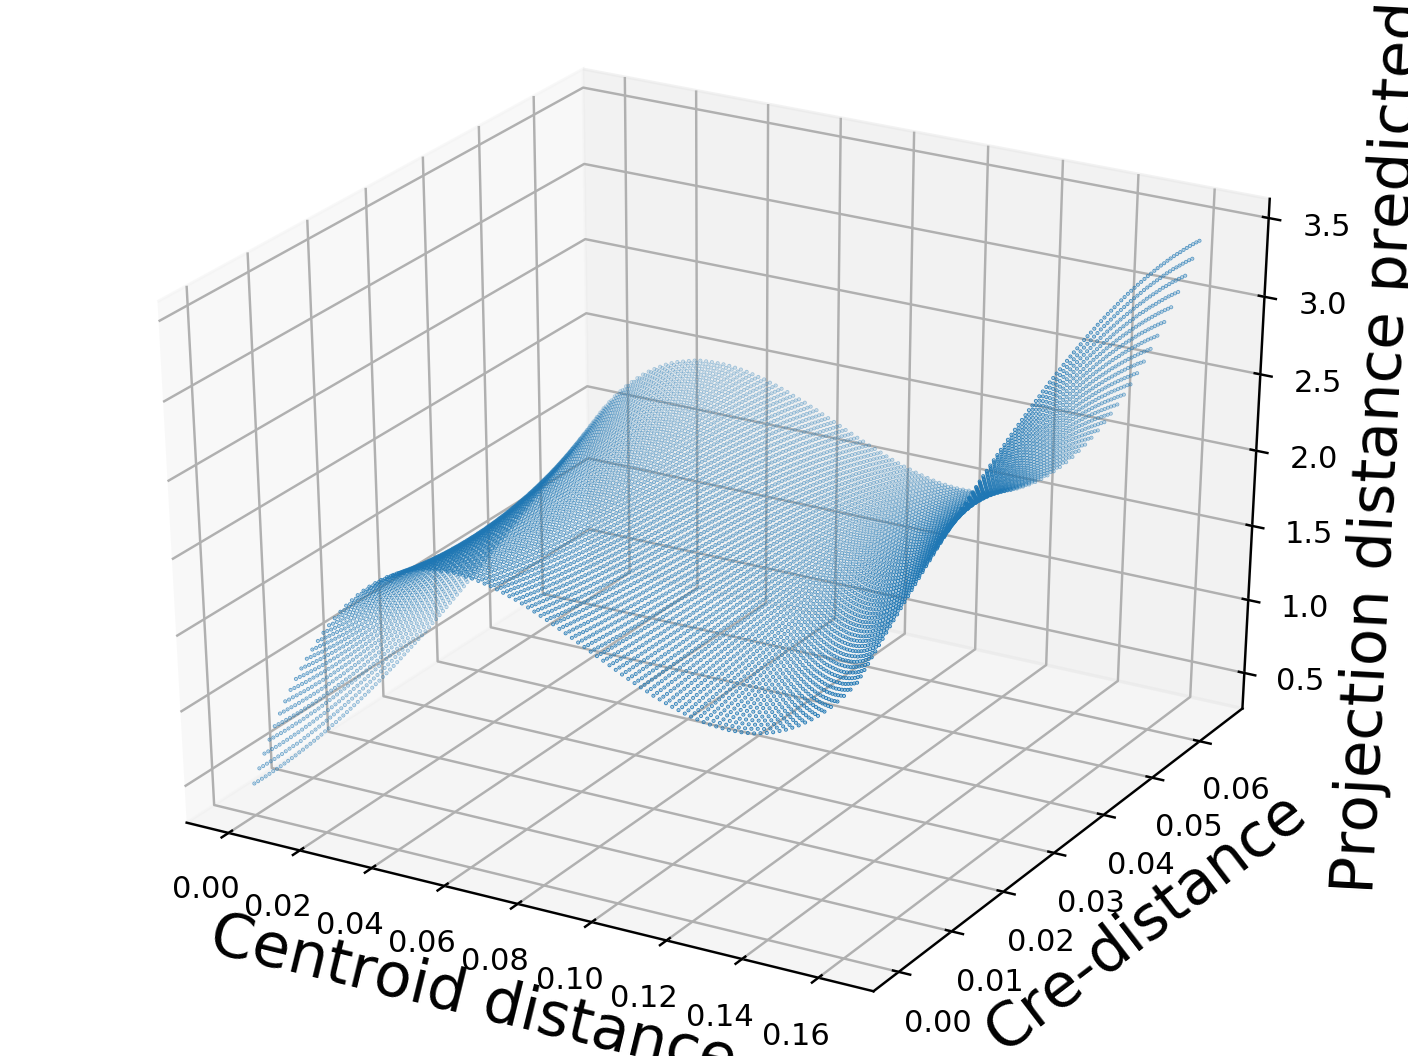

Text(0.5, 0, 'Projection distance predicted')

In [481]:

# %matplotlib notebook

# qqq = KernelRidge(kernel='rbf', alpha=0, gamma  = .05)
# qqq.fit(dc[:,:2], dc[:,2:])
# xs = np.linspace(0, dc[:,0].max(), 100)
# ys = np.linspace(0, dc[:,1].max(), 100)
# preds = np.empty((100,100))
# for x in range(100):
#     for y in range(100):
#         preds[x,y] =qqq.predict(np.asarray([[xs[x], ys[y]]]))#asdf.predict(np.asarray([[xs[x], ys[y]]])) #qqq.predict(np.asarray([[xs[x], ys[y]]]))
        
        
        
# mxy = np.asarray(np.meshgrid(xs,ys)).transpose()

# #%matplotlib inline
# fig = plt.figure()
# ax = Axes3D(fig)

# ax.scatter(mxy[:,:,0], 
#            mxy[:,:,1], 
#            preds, s= .1)

# #ax.set_axis_off()
# ax.set_xlabel('Centroid distance', fontsize=20, rotation=150)
# ax.set_ylabel('Cre-distance', fontsize=20, rotation=150)
# ax.set_zlabel('Projection distance predicted', fontsize=20, rotation=150)

In [234]:
dat = pd.DataFrame([ds2.flatten(), cs2.flatten(),ls2.flatten()]).transpose()

In [235]:
dat.columns = ['Centroid dist', 'Cre dist','Proj dist']

<IPython.core.display.Javascript object>


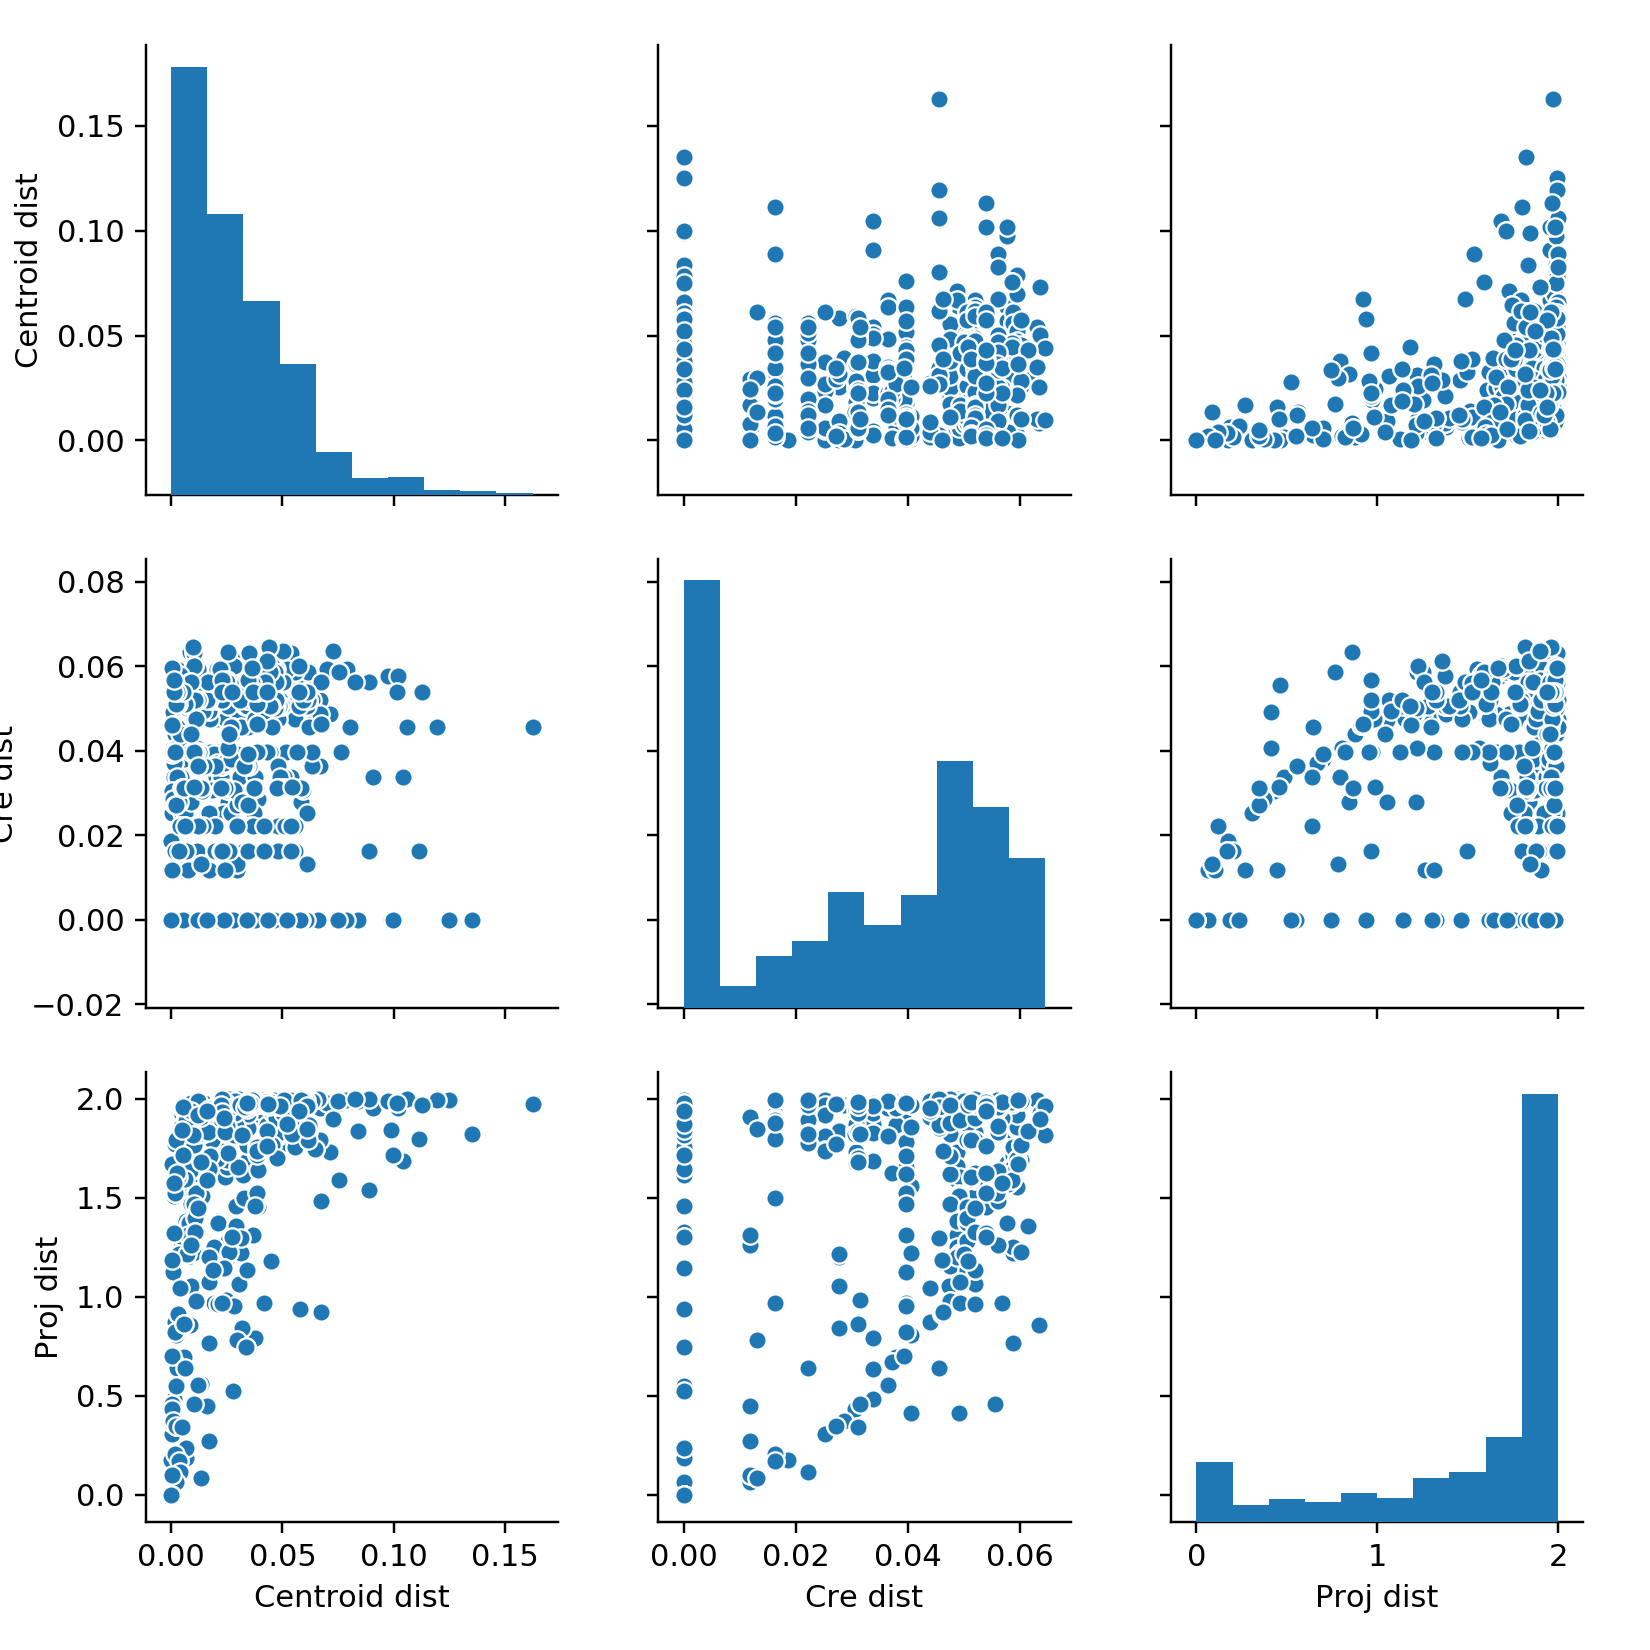

In [236]:
sns.pairplot(dat)

In [9]:
#     data_melted = data_melted.astype({'value': np.float64})
#     means = data_melted.groupby(by=['variable', 'cre'])['value'].mean().reset_index()
#     means_cast = pd.pivot_table(means, index = 'cre', columns = 'variable')
#     means_cast.columns = means_cast.columns.get_level_values(1)
#     #means_cast.index = means_cast.index.get_level_values(1)
#     #sns.boxplot(x = creline[sid][es[sid]], y = ls[sid][gs[m,0]], ax=ax, order = order)

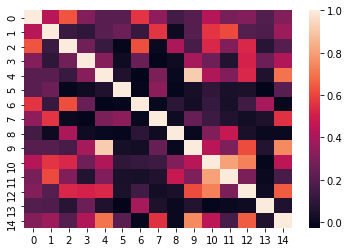

In [15]:
sns.heatmap(np.corrcoef(means_cast))

In [13]:
#means_cast.shape

(15, 291)

In [17]:
#data_melted

,cre,variable,value
0,C57BL/6J,FRP,0.000473
1,Pcp2-Cre_GN135,FRP,0.008710
2,Gad2-IRES-Cre,FRP,0.070609
3,C57BL/6J,FRP,0.062011
4,Pcp2-Cre_GN135,FRP,0.003095
...,...,...,...
20767,Ppp1r17-Cre_NL146,DN,0.000000
20768,Scnn1a-Tg3-Cre,DN,0.002752
20769,Grm2-Cre_MR90,DN,0.006364
20770,Pvalb-IRES-Cre,DN,0.000025


In [6]:
from sklearn.metrics.pairwise import pairwise_kernels
from mcmodels.regressors.nonparametric.nadaraya_watson import get_weights

def get_best_hyperparameters(losses, keys):
    
    major_structure_ids = np.asarray(list(losses.keys()))
    nms = len(major_structure_ids)
    nkey = keys.shape[1]
    output = np.empty((nms, nkey))
    for m in range(nms):
        print(m)
        sid = major_structure_ids[m]
        lvec = np.asarray([np.nanmean(losses[sid][key]) for key in keys])
        if np.any(~np.isnan(lvec)):
            output[m] = keys[np.nanargmin(lvec)]
        # if len(np.where(np.isnan(np.nanmean(losses[sid][:,:], axis = 1)))[0]) < losses[sid].shape[0]:
        #    output[m] = np.nanargmin(np.nanmean(losses[sid][:,:], axis = 1))

    output = np.asarray(output, dtype=int)
    return(output)

#get where we actually modelled
def get_eval_indices(eval_index_matrices):
    eval_indices = {}
    major_structure_ids = np.asarray(list(eval_index_matrices.keys()))
    for sid in major_structure_ids:
        eval_indices[sid] = np.where(eval_index_matrices[sid].sum(axis = 0) > 0)[0]
    return(eval_indices)    



def get_weights(eval_centroids, model_centroids, gamma):
    weights = pairwise_kernels(X=eval_centroids, Y=model_centroids, metric='rbf', gamma=gamma, filter_params=True)
    return (weights)


def get_indices(ids):

    ids_unique = np.unique(ids)
    output = np.zeros((len(ids_unique), len(ids)), dtype = int)
    for i in range(len(ids_unique)):
        output[i,np.where(ids == ids_unique[i])[0] ] = 1
    return(output)

#get indices of firstlist in firstlisttest in categories defined by secondlist
def get_indices2(firstlist, firstlisttest, secondlist):
    
    sl_unique = np.unique(secondlist)
    output = np.zeros((len(sl_unique), len(secondlist)), dtype = int)
    for i in range(len(sl_unique)):
        output[i,np.intersect1d(np.where(np.isin(firstlist,firstlisttest))[0], np.where(secondlist == sl_unique[i])[0])] = 1
    return(output)

#nmodels = nleafs
#populate each with experiments that share summary structure
def get_indices_summaryinleaf(summarylist , leaflist):
    
    nexp = len(leaflist)
    leaf_unique = np.unique(leaflist)
    output = np.zeros((len(leaf_unique), nexp), dtype = int)
    
    for i in range(len(leaf_unique)):
        
        summary = summarylist[np.where(leaflist == leaf_unique[i])[0]][0]
        output[i,np.where(summarylist == summary)[0]] = 1
        
        
    return(output)

#get predictions at all eval_indices using model_indices
#if an eval_indices is also a model indice, leave it out of the model
#if a model index is not an eval index, it never gets left out
def get_nwloocv_predictions_singlemodel(projections, centroids, gamma, model_indices, eval_indices):
  
    eval_index_val = np.where(eval_indices == 1)[0]
    model_index_val = np.where(model_indices == 1)[0]
    
    projections = np.asarray(projections, dtype=np.float32)
    
    nmod_ind = len(model_index_val)
    neval = len(eval_index_val)
    #nexp = centroids.shape[0]
    predictions = np.empty(projections.shape)
    #print(model_index_val.shape, eval_index_val.shape)

    if len(model_index_val) > 0 and  len(eval_index_val) > 0:
        weights = pairwise_kernels(centroids[model_index_val], centroids[eval_index_val], metric='rbf', gamma=gamma, filter_params=True) #get_weights(centroids, gamma)
        for i in range(neval):
            matchindex = np.where(model_index_val == eval_index_val[i])[0]
            otherindices = np.setdiff1d(np.asarray(list(range(nmod_ind))), matchindex)         
            #this order of operations is the fastest I found
            weights_i = weights[:,i] / weights[:,i][otherindices].sum()
            weights_i[matchindex] = 0
            weights_i = np.asarray(weights_i, dtype=np.float32)
            pred = np.dot(weights_i, projections[model_index_val])
            predictions[eval_index_val[i]] = pred

        
    return(predictions)    

def get_nwloocv_predictions_multimodel(projections, centroids, gammas, model_index_matrix, eval_index_matrix):
    

    
    ntargets = projections.shape[1]
    nexp = projections.shape[0]
    nmodels = model_index_matrix.shape[0]
    ngammas = len(gammas)
    
    projections = np.asarray(projections, dtype=np.float32)
    predictions = np.empty((nmodels, ngammas, nexp, ntargets))
    
    
    for m in range(nmodels):
        #print('m', m, len(np.where(model_index_matrix[m] ==1)[0]))
        predictions[m] = np.asarray([get_nwloocv_predictions_singlemodel(projections, centroids, gammas[g], model_index_matrix[m], eval_index_matrix[m]) for g in range(ngammas)])
    
    return(predictions)  

def combine_predictions(predictions, eval_index_matrix):
    
    nmodels, ngammas, nexp, ntargets = predictions.shape
    combined_predictions = np.empty((ngammas, nexp, ntargets))
    for m in range(nmodels):
        combined_predictions[:,np.where(eval_index_matrix[m] == 1)[0]] = predictions[m][:,np.where(eval_index_matrix[m] == 1)[0]]
        
    return(combined_predictions)

def get_nwloocv_predictions_multimodel_merge(projections, centroids, gammas, model_index_matrix, eval_index_matrix):
    
    predictions_unmerged = get_nwloocv_predictions_multimodel(projections, centroids, gammas, model_index_matrix, eval_index_matrix)
    print(predictions_unmerged.shape)
    predictions_merged = combine_predictions(predictions_unmerged, eval_index_matrix)
    
    return(predictions_merged)

#we should not pass model_index_matrices that are identical to eval_index_matrices and have only 1 element per model
#although in principal we could do automatically in the cross validation code 
#we would rather do it explicitly to ensure identical indexing b/w experiments
#if we only have 1 model index we will remove the model index from eval indices
def screen_indices(model_indices, eval_indices):
    
    eval_indices2 = eval_indices.copy()
    mod_loc = np.where(model_indices == 1)[0]
    if len(mod_loc) == 1:
        eval_indices2[mod_loc] = 0
    return(eval_indices2)

#this could result in an empty eval index i.e. certain indices having no prediction.  catch later
#can merge (sum) the index matrix to see where predictions are actually generated
def screen_index_matrices(model_index_matrices, eval_index_matrices):
    
    #alter eval_indices to remove model index in cases where there is only one experiment in the model
    
    nmodels = model_index_matrices.shape[0]
    eval_index_matrices2 = eval_index_matrices.copy()
    for m in range(nmodels):
        eval_index_matrices2[m] = screen_indices(model_index_matrices[m], eval_index_matrices[m])
    
    return(eval_index_matrices2)

#need code for removing experiments that have no model
#this can happen when the model set is a subset of the evaluation set.
#we will therefore generate predictions for a subset
#given a leaf is included, the eval set is the same
#however, we want to remove evals in leaves we don't have a wt for... of course one could say we are doing worse...
#but we also have a fewer number of models
#model_index_matrices are the indices of the leafs'
#indices_wtinleaf are the wild types
#need to make sure we dont have leafs with only 1 experiment


def screen_index_matrices2(model_index_matrices, eval_index_matrices):
    
    #alter model and eval matrices to be nonzero only when there are at least two experiments in the model
    #it can be useful for when model_index_matrices is a subset of eval_index_matrices
    #nmodels = model_index_matrices.shape[0]
    include_per_model = model_index_matrices.sum(axis= 1)
    to_exclude = np.where(include_per_model <= 1)[0]
    #to_include = np.where(include_per_model > 0)[0]
    
    model_index_matrices2 = model_index_matrices.copy()
    eval_index_matrices2 = eval_index_matrices.copy()
    model_index_matrices2[to_exclude] = 0
    eval_index_matrices2[to_exclude] = 0
    
    return(model_index_matrices2, eval_index_matrices2)

def screen_index_matrices3(model_index_matrices, eval_index_matrices):
    
    #alter model and eval matrices to be nonzero only when there are at least one experiments in the model
    #it can be useful for when model_index_matrices is a subset of eval_index_matrices
    #nmodels = model_index_matrices.shape[0]
    include_per_model = model_index_matrices.sum(axis= 1)
    to_exclude = np.where(include_per_model < 1)[0]
    #to_include = np.where(include_per_model > 0)[0]
    
    model_index_matrices2 = model_index_matrices.copy()
    eval_index_matrices2 = eval_index_matrices.copy()
    model_index_matrices2[to_exclude] = 0
    eval_index_matrices2[to_exclude] = 0
    
    to_remove = np.where(include_per_model == 1)[0]
    eval_index_matrices2[to_remove] = 0
    
    return(model_index_matrices2, eval_index_matrices2)

In [7]:
indices_leaf = {}
indices_wtinleaf = {}
indices_wtleaf = {}
indices_summary = {}
indices_summaryinleaf = {}
indices_major = {}
indices_majorinleaf = {}
indices_leaf2ormore = {}
indices_wtinleaf2ormore = {}
indices_leaf_reduced = {}
indices_wtinleaf_reduced = {}
indices_wt_leaf2ormore = {}
indices_leaf2ormore_wt = {}
indices_wt1ormore_leaf2ormore = {}
indices_leaf2ormore_wt1ormore = {}
for sid in major_structure_ids:
    
    #wt_leaf on leaf

    #get the indices of experiments sharing leafs (nmodels is number of leafs)
    indices_leaf[sid] = get_indices(leafs[sid]) #eval_indices
    #indices_creleaf = get_indices(leafs[sid])
    
    #get the indices of the wts in the leaf (nmodels is number of leafs)
    indices_wtinleaf[sid] = get_indices2(creline[sid], np.asarray(['C57BL/6J']),leafs[sid]) #model_indices
    
    #get indices of experiments sharing summary structure x cre combination (nmodel is number of cre x leaf combinations)
    #indices_wtleaf[sid] = get_indices(creleafs_merged[sid])
    
    #get indices of experiments sharing summary structure(nmodel is number of summary structures)
    indices_summary[sid] = get_indices(experiments_minor_structures[sid])
    
    #get indices of experiments sharing major structure(nmodel is number of summary structures)
    indices_major[sid] = np.ones((1,experiments_minor_structures[sid].shape[0]))
    
    #get indices of experiments sharing same major structure as a leaf (nmodel is number of leafs)
    indices_majorinleaf[sid] = np.ones((len(np.unique(leafs[sid])),experiments_minor_structures[sid].shape[0]))#get_indices2(np.ones(len(leafs[sid])), np.asarray([1]),leafs[sid]) #model_indices
    
    #get indices of experiments in same summary structure as a leaf (nmodel is number of leafs)
    indices_summaryinleaf[sid] = get_indices_summaryinleaf(experiments_minor_structures[sid], leafs[sid])
    
    #evaluate models on leafs
    indices_leaf2ormore[sid] = screen_index_matrices(indices_leaf[sid], indices_leaf[sid])
    
    indices_wt1ormore_leaf2ormore[sid], indices_leaf2ormore_wt1ormore[sid] = screen_index_matrices3(indices_wtinleaf[sid], indices_leaf2ormore[sid])
    
    indices_wtinleaf2ormore[sid] = screen_index_matrices(indices_wtinleaf[sid], indices_wtinleaf[sid])
    indices_leaf_reduced[sid], indices_wtinleaf_reduced[sid]  = screen_index_matrices2( indices_leaf2ormore[sid],indices_wtinleaf[sid])


In [8]:
#nwloocv_leaf_leaf2[512][0].sum(axis = 1)

Stefan's approach is to identify pairse 'cre scores' such as the distance between means of different cre lines in the same group. We can then learn the surface giving loss from centroid distance and cre score.

Consider a regime where loss is used only. Hopefully, the learned relationship between centroid distance and projection distance is not overfit.  Consider the surface learning method.  I used a kernel method, so the predicted loss is the sum of the loss of the nearby pairs. That is
\begin{eqnarray*}
\hat l_{ij} = \sum_{L \in S} \sum_{i'j' \in \text{L}} e^{-\|d_{ij} - d_{i'j'}\|_2^2} l_{i'j'}  %= \sum_{i'j'} e^{-\|d_{ij} - d_{i'j'}\|_2^2}.
\end{eqnarray*}
This statistic estimates how typically wrong are predictions from a pair of points at this distance. It assumes equal decay in every direction.
We then use $\hat d_{ij} = \hat l_{ij} $, 
that is,
\begin{eqnarray*}
\hat y_i = \sum_{j} e^{- \|\hat l_{ij}\|_2^2} y_j
\end{eqnarray*}
in the final kernel regression step.
The utility of this additional smoothing method is subtle; a simpler approach would be to featurize the cre-score directly. However, we can see the usefulness from the two examples. First, suppose that the the relationship is linear only in distance.  A larger slope would correspond to a lower gamma.  On the other hand, when the cre-score is included, we can identify a trade-off between the cre-score and the distance.  The level sets of the learned relationship between the loss and the cre-score / distance specify this relationship within a neighborhood size.


In [10]:
def get_nwloocv_predictions_multimodel_merge_dists(projections, dists, gammas, model_index_matrix, eval_index_matrix):
    
    predictions_unmerged = get_nwloocv_predictions_multimodel_dists(projections, dists, gammas, model_index_matrix, eval_index_matrix)
    print(predictions_unmerged.shape)
    predictions_merged = combine_predictions(predictions_unmerged, eval_index_matrix)
    
    return(predictions_merged)
    
    
def get_nwloocv_predictions_multimodel_dists(projections, dists, gammas, model_index_matrix, eval_index_matrix):
    

    
    ntargets = projections.shape[1]
    nexp = projections.shape[0]
    nmodels = model_index_matrix.shape[0]
    ngammas = len(gammas)
    
    projections = np.asarray(projections, dtype=np.float32)
    predictions = np.empty((nmodels, ngammas, nexp, ntargets))
    
    
    for m in range(nmodels):
        #print('m', m, len(np.where(model_index_matrix[m] ==1)[0]))
        predictions[m] = np.asarray([get_nwloocv_predictions_singlemodel_dists(projections, dists, gammas[g], model_index_matrix[m], eval_index_matrix[m]) for g in range(ngammas)])
    
    return(predictions)  


In [11]:
# def get_nwloocv_predictions_singlemodel_dists(projections, dists, gamma, model_indices, eval_indices):
  
#     eval_index_val = np.where(eval_indices == 1)[0]
#     model_index_val = np.where(model_indices == 1)[0]
    
#     projections = np.asarray(projections, dtype=np.float32)
    
#     nmod_ind = len(model_index_val)
#     neval = len(eval_index_val)
#     #nexp = centroids.shape[0]
#     predictions = np.empty(projections.shape)
#     #print(model_index_val.shape, eval_index_val.shape)

#     if len(model_index_val) > 0 and  len(eval_index_val) > 0:
#         weights = np.exp(-dists[model_index_val] / gamma) #get_weights(centroids, gamma)
#         for i in range(neval):
#             matchindex = np.where(model_index_val == eval_index_val[i])[0]
#             otherindices = np.setdiff1d(np.asarray(list(range(nmod_ind))), matchindex)         
#             #this order of operations is the fastest I found
#             weights_i = weights[:,i] / weights[:,i][otherindices].sum()
#             weights_i[matchindex] = 0
#             weights_i = np.asarray(weights_i, dtype=np.float32)
#             pred = np.dot(weights_i, projections[model_index_val])
#             predictions[eval_index_val[i]] = pred

        
#     return(predictions) 

In [12]:
# bbbb = np.asarray(np.where(~np.isnan(cs))).transpose()
# smoothedlosses = np.empty((36,36))
# smoothedlosses[:] = np.nan
# for i in range(bbbb.shape[0]):
#     ci = cs[bbbb[i,0], bbbb[i,1]] / csnorm
#     di = ds[bbbb[i,0], bbbb[i,1]] / dsnorm
#     smoothedlosses[bbbb[i,0], bbbb[i,1]] = qqq.predict(np.asarray([[ci, di]]))
#     print(smoothedlosses[bbbb[i,0], bbbb[i,1]])

In [13]:
# projections = msvds[sid].reg_proj_vcount_norm_renorm
# dists= smoothedlosses
# model_index_matrix = indices_leaf2ormore[sid]
# eval_index_matrix = indices_leaf2ormore[sid]
#                                                                                        #, 
#                                                                                        #indices_leaf2ormore[sid]

In [14]:
#     predictions_unmerged = get_nwloocv_predictions_multimodel_dists(projections, dists, gammas, model_index_matrix, eval_index_matrix)
#     print(predictions_unmerged.shape)
#     predictions_merged = combine_predictions(predictions_unmerged, eval_index_matrix)


In [15]:
#     ntargets = projections.shape[1]
#     nexp = projections.shape[0]
#     nmodels = model_index_matrix.shape[0]
#     ngammas = len(gammas)
    
#     projections = np.asarray(projections, dtype=np.float32)
#     predictions = np.empty((nmodels, ngammas, nexp, ntargets))
    
    
#     for m in range(nmodels):
#         #print('m', m, len(np.where(model_index_matrix[m] ==1)[0]))
#         predictions[m] = np.asarray([get_nwloocv_predictions_singlemodel_dists(projections, dists, gammas[g], model_index_matrix[m], eval_index_matrix[m]) for g in range(ngammas)])


In [16]:
def get_nwloocv_predictions_singlemodel_dists(projections, dists, gamma, model_indices, eval_indices):
  
    eval_index_val = np.where(eval_indices == 1)[0]
    model_index_val = np.where(model_indices == 1)[0]
    
    projections = np.asarray(projections, dtype=np.float32)
    
    nmod_ind = len(model_index_val)
    neval = len(eval_index_val)
    #nexp = centroids.shape[0]
    predictions = np.empty(projections.shape)
    #print(model_index_val.shape, eval_index_val.shape)

    if len(model_index_val) > 0 and  len(eval_index_val) > 0:
        weights = np.exp(-dists[model_index_val][:, eval_index_val] / gamma)#np.exp(-dists[model_index_val] / gamma) #get_weights(centroids, gamma)
        for i in range(neval):
            matchindex = np.where(model_index_val == eval_index_val[i])[0]
            otherindices = np.setdiff1d(np.asarray(list(range(nmod_ind))), matchindex)         
            #this order of operations is the fastest I found
            weights_i = weights[:,i] / weights[:,i][otherindices].sum()
            weights_i[matchindex] = 0
            weights_i = np.asarray(weights_i, dtype=np.float32)
            pred = np.dot(weights_i, projections[model_index_val])
            predictions[eval_index_val[i]] = pred

        
    return(predictions) 

In [17]:
# ntargets = projections.shape[1]
# nexp = projections.shape[0]
# nmodels = model_index_matrix.shape[0]
# ngammas = len(gammas)

# projections = np.asarray(projections, dtype=np.float32)
# predictions = np.empty((nmodels, ngammas, nexp, ntargets))

# m = 1
# #model_index_matrix[0]

# predictions[m] = np.asarray([get_nwloocv_predictions_singlemodel_dists(projections, dists, gammas[g], model_index_matrix[m], eval_index_matrix[m]) for g in range(ngammas)])
# print(predictions.shape)
# predictions[1][0][6][:5]
# #its the 5th of the evals, which index?
# eval_indices_leaf2ormore[512][5]
# #which model is the 6th point in?
# model_index_matrix[:,6]
# m = 1
# model_indices = model_index_matrix[m]
# model_index_val = np.where(model_indices == 1)[0]
# print(model_index_val)
# eval_indices = eval_index_matrix[m]
# eval_index_val = np.where(eval_indices == 1)[0]
# eval_index_val = np.where(eval_indices == 1)[0]
# model_index_val = np.where(model_indices == 1)[0]
# gamma = .1
# projections = np.asarray(projections, dtype=np.float32)

# nmod_ind = len(model_index_val)
# neval = len(eval_index_val)
# #nexp = centroids.shape[0]
# predictions = np.empty(projections.shape)
# #print(model_index_val.shape, eval_index_val.shape)

# if len(model_index_val) > 0 and  len(eval_index_val) > 0:
#     weights = np.exp(-dists[model_index_val][:, eval_index_val] / gamma) #get_weights(centroids, gamma)
#     #for i in range(neval):
#     i = 0
#     matchindex = np.where(model_index_val == eval_index_val[i])[0]
#     otherindices = np.setdiff1d(np.asarray(list(range(nmod_ind))), matchindex)         
#     #this order of operations is the fastest I found
#     weights_i = weights[:,i] / weights[:,i][otherindices].sum()
#     weights_i[matchindex] = 0
#     weights_i = np.asarray(weights_i, dtype=np.float32)
#     pred = np.dot(weights_i, projections[model_index_val])
#     predictions[eval_index_val[i]] = pred
# pred

In [18]:
msvd = msvds[sid]
cres = creline[sid]
eminors = experiments_minor_structures[sid]
def get_cre_similarity(msvd, cres,eminors):

    #sid = 512
    data_merged = pd.DataFrame(np.hstack([np.expand_dims(cres,1),np.expand_dims(eminors,1),msvd.reg_proj_vcount_norm_renorm ]), columns = np.append(['cre','injsum'],colnames))
    data_melted = pd.melt(data_merged, id_vars=['cre','injsum'])
    data_melted = data_melted.astype({'value': np.float64})
    means = data_melted.groupby(by=['variable', 'cre','injsum'])['value'].mean().reset_index()
    means = means.astype({'value': np.float64})
    means_cast = pd.pivot_table(means, index = ['injsum','cre'], columns = 'variable')
    means_cast.columns = means_cast.columns.get_level_values(1)
    #pairwise_distances(means_cast)
    cs = np.asarray(list(means_cast.index))
    
    return(means_cast,cs)

In [19]:
def get_mean_dist(means_cast):
    cs = np.asarray(list(means_cast.index))
    results = {}
    reg = np.unique(cs[:,0])
    nreg = len(reg)
    for i in range(nreg):
        results[reg[i]] = {}
        reg_cre_ind = np.where(cs[:,0] == reg[i])[0]
        for j in range(len(reg_cre_ind)):
            for k in range(len(reg_cre_ind)):
                results[reg[i]][tuple([cs[reg_cre_ind[j],1], cs[reg_cre_ind[k],1]])] = np.linalg.norm(means_cast.iloc[reg_cre_ind[j]] - means_cast.iloc[reg_cre_ind[k]])
    return(results)

In [20]:
def get_cre_dist(results, eminors,cres):
    nsamp = cres.shape[0]
    credist = np.empty((nsamp,nsamp))
    credist[:] = np.nan
    for i in range(nsamp):
        rkeys = list(results[eminors[i]].keys())#np.asarray(list(results[experiments_minor_structures[sid][i]].keys()))
        for j in range(nsamp):
            t= tuple([cres[i], cres[j]])
            if np.isin(t, rkeys).all():
                credist[i,j]  = results[eminors[i]][t]
    return(credist)

In [21]:
import random
random.seed(1)
np.random.seed(1)

In [34]:
# def get_loss_surface(msvd,cre_dist, fraction):
#     ds = pairwise_distances(msvd.centroids)**2
#     cs = cre_dist
#     ls = pairwise_distances(msvd.reg_proj_vcount_norm_renorm)**2
#     nsamp = msvd.centroids.shape[0]
#     #need source and target color
#     source = np.repeat(np.linspace(0,nsamp - 1, nsamp, dtype = int), nsamp)
#     target = np.tile(np.linspace(0,nsamp - 1, nsamp, dtype = int), nsamp)

#     ds2 = ds[np.where(~np.isnan(cs))]
#     cs2 = cs[np.where(~np.isnan(cs))]
#     source2 = source[np.where(~np.isnan(cs.flatten()))]
#     target2 = target[np.where(~np.isnan(cs.flatten()))]

#     dsnorm  = np.linalg.norm(ds2)
#     csnorm = np.linalg.norm(cs2)

#     ds2 = ds2/dsnorm
#     cs2 = cs2 / csnorm
#     ls2 = ls[np.where(~np.isnan(cs))]

#     dc = np.asarray([ds2,cs2,ls2]).transpose()
#     #ids = np.linspace(0,35, 36, dtype = int), 36)

#     qqq = KernelRidge(kernel='rbf', alpha=0, gamma  = .05)
#     qqq.fit(dc[:,:2], dc[:,2:])
#     return(qqq)
# # xs = np.linspace(0, dc[:,0].max(), 100)
# # ys = np.linspace(0, dc[:,1].max(), 100)
# # preds = np.empty((100,100))
# # for x in range(100):
# #     for y in range(100):
# #         preds[x,y] =qqq.predict(np.asarray([[xs[x], ys[y]]]))#asdf.predict(np.asarray([[xs[x], ys[y]]])) #qqq.predict(np.asarray([[xs[x], ys[y]]]))

In [61]:
fraction = 1.

In [62]:
ngp = 5

In [63]:
import math

[1, 3, 2, 0, 4]

In [68]:
def get_loss_surface(msvd,cre_dist, fraction):
    #ds = pairwise_distances(msvd.centroids)**2
    cs = cre_dist
    #ls = pairwise_distances(msvd.reg_proj_vcount_norm_renorm)**2
    nsamp = msvd.centroids.shape[0]
    #need source and target color
    source = np.repeat(np.linspace(0,nsamp - 1, nsamp, dtype = int), nsamp)
    target = np.tile(np.linspace(0,nsamp - 1, nsamp, dtype = int), nsamp)
    goodpairs = np.asarray(np.where(~np.isnan(cs))).transpose()
    ngp = goodpairs.shape[0]
    centroids = msvd.centroids
    projs = msvd.reg_proj_vcount_norm_renorm
    ds2 = np.zeros(ngp)
    ls2 = np.zeros(ngp)
    for i in range(ngp):
        print(i)
        ds2[i] = np.linalg.norm(centroids[goodpairs[i][0]] - centroids[goodpairs[i][1]])**2
        ls2[i] = np.linalg.norm(projs[goodpairs[i][0]] - projs[goodpairs[i][1]])**2
        
    cs2 = cs[np.where(~np.isnan(cs))]    
    #ds2 = ds[np.where(~np.isnan(cs))]
    #
    source2 = source[np.where(~np.isnan(cs.flatten()))]
    target2 = target[np.where(~np.isnan(cs.flatten()))]

    dsnorm  = np.linalg.norm(ds2)
    csnorm = np.linalg.norm(cs2)

    ds2 = ds2 / dsnorm
    cs2 = cs2 / csnorm
    #ls2 = ls[np.where(~np.isnan(cs))]

    dc = np.asarray([ds2,cs2,ls2]).transpose()
    #ids = np.linspace(0,35, 36, dtype = int), 36)
    
    qqq = KernelRidge(kernel='rbf', alpha=0, gamma  = .05)
    randos = random.sample(list(range(ngp)), math.floor(ngp * fraction))
    qqq.fit(dc[:,:2][randos], dc[:,2:][randos])
    #return(qqq)
# xs = np.linspace(0, dc[:,0].max(), 100)
# ys = np.linspace(0, dc[:,1].max(), 100)
# preds = np.empty((100,100))
# for x in range(100):
#     for y in range(100):
#         preds[x,y] =qqq.predict(np.asarray([[xs[x], ys[y]]]))#asdf.predict(np.asarray([[xs[x], ys[y]]])) #qqq.predict(np.asarray([[xs[x], ys[y]]]))
    return(qqq)
# xs = np.linspace(0, dc[:,0].max(), 100)
# ys = np.linspace(0, dc[:,1].max(), 100)
# preds = np.empty((100,100))
# for x in range(100):
#     for y in range(100):
#         preds[x,y] =qqq.predict(np.asarray([[xs[x], ys[y]]]))#asdf.predict(np.asarray([[xs[x], ys[y]]])) #qqq.predict(np.asarray([[xs[x], ys[y]]]))

In [69]:
def get_smoothed_losses(msvd, qqq, cre_dist):
    ds = pairwise_distances(msvd.centroids)**2
    cs = cre_dist
    ds2 = ds[np.where(~np.isnan(cs))]
    cs2 = cs[np.where(~np.isnan(cs))]
    dsnorm  = np.linalg.norm(ds2)
    csnorm = np.linalg.norm(cs2)
    
    ls = pairwise_distances(msvd.reg_proj_vcount_norm_renorm)**2
    nsamp = ds.shape[0]
    bbbb = np.asarray(np.where(~np.isnan(cs))).transpose()
    smoothedlosses = np.empty((nsamp,nsamp))
    smoothedlosses[:] = np.nan
    for i in range(bbbb.shape[0]):
        ci = cs[bbbb[i,0], bbbb[i,1]] / csnorm
        di = ds[bbbb[i,0], bbbb[i,1]] / dsnorm
        smoothedlosses[bbbb[i,0], bbbb[i,1]] = qqq.predict(np.asarray([[ci, di]]))
    return(smoothedlosses)

In [70]:
# results = {}
# reg = np.unique(cs[:,0])
# nreg = len(reg)
# for i in range(nreg):
#     results[reg[i]] = {}
#     reg_cre_ind = np.where(cs[:,0] == reg[i])[0]
#     for j in range(len(reg_cre_ind)):
#         for k in range(len(reg_cre_ind)):
#             results[reg[i]][tuple([cs[reg_cre_ind[j],1], cs[reg_cre_ind[k],1]])] = np.linalg.norm(means_cast.iloc[reg_cre_ind[j]] - means_cast.iloc[reg_cre_ind[k]])
#     #results[cs[i,0]][tuple(cs[j,1], cs2[i,1])] = results[cs[i,0]][tuple(cs[i,1], cs2[j,1])] 
    
# nsamp = 36
# credist = np.empty((nsamp,nsamp))
# credist[:] = np.nan
# for i in range(nsamp):
#     rkeys = list(results[experiments_minor_structures[sid][i]].keys())#np.asarray(list(results[experiments_minor_structures[sid][i]].keys()))
#     for j in range(nsamp):
#         t= tuple([creline[sid][i], creline[sid][j]])
#         if np.isin(t, rkeys).all():
#             credist[i,j]  = results[experiments_minor_structures[sid][i]][t]

In [71]:
# bbbb = np.asarray(np.where(~np.isnan(cs))).transpose()
# smoothedlosses = np.empty((36,36))
# smoothedlosses[:] = np.nan
# for i in range(bbbb.shape[0]):
#     ci = cs[bbbb[i,0], bbbb[i,1]] / csnorm
#     di = ds[bbbb[i,0], bbbb[i,1]] / dsnorm
#     smoothedlosses[bbbb[i,0], bbbb[i,1]] = qqq.predict(np.asarray([[ci, di]]))
#     print(smoothedlosses[bbbb[i,0], bbbb[i,1]])

In [72]:
from itertools import product
def get_cre_dist2(results, eminors,cres):
    nsamp = cres.shape[0]
    cretypes = np.unique(cres)
    credist = np.empty((nsamp,nsamp))
    credist[:] = np.nan
    ncre= len(cretypes)
    rkeys = list(results.keys())
    for r in range(len(rkeys)):
        print(r)
        rkey = rkeys[r] #this is the minor structure
        e_s = np.where(eminors == rkey)[0]
        possibilikeys = list(results[rkey].keys()) #these are the possible cre combinations
        for i in range(ncre):
            i_s = np.where(cres == cretypes[i])[0]
            for j in range(ncre):
                j_s = np.where(cres == cretypes[j])[0]
                
                t= tuple([cretypes[i], cretypes[j]])
                if np.isin(t, possibilikeys).all():
                    #print(t, i_s, j_s)
                    #print(i_s, j_s,results[rkey][t])
                    #nnn = np.asarray(results[rkey][t] * np.ones(credist[i_s][:,j_s].shape))
                    #print(r,i,j)
                    tomod = list(product(np.intersect1d(i_s, e_s), np.intersect1d(j_s, e_s)))
                    #print(np.intersect1d(i_s, e_s))
                    for m in range(len(tomod)):
                        credist[tomod[m][0], tomod[m][1]] = results[rkey][t]
                    #credist[i_s][:,j_s] = nnn
    return(credist)

In [90]:
sls = {}
frac_learn = np.ones(12)
frac_learn[4] = .05
for m in range(12):
    sid = major_structure_ids[m]
    #for sid in np.asarray(major_structure_ids[:1]):#[np.asarray([0,1,2,3,4,5,6,7,8,9,10,11], dtype = int)]:
    print(sid)
    msvd = msvds[sid]
    cres = creline[sid]
    eminors = experiments_minor_structures[sid]
    means_cast, cs = get_cre_similarity(msvd, cres,eminors)
    mean_dist = get_mean_dist(means_cast)
    #cre_dist = get_cre_dist(mean_dist, eminors,cres)
    cre_dist2 = get_cre_dist2(mean_dist, eminors,cres)
    qqq = get_loss_surface(msvd, cre_dist2,frac_learn[m])
    sls[sid] = get_smoothed_losses(msvd,qqq, cre_dist2)

512
0
1
2
3
4
5
6
7
8
9
10
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
703


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "


0
1
2
3
0
1
2
3
4
5
6
7
8
9
10
11
12
1089
0
1
2
3
4
5
6
7
8
9
10
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
2

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "


1097
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "


315
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
24

2514
2515
2516
2517
2518
2519
2520
2521
2522
2523
2524
2525
2526
2527
2528
2529
2530
2531
2532
2533
2534
2535
2536
2537
2538
2539
2540
2541
2542
2543
2544
2545
2546
2547
2548
2549
2550
2551
2552
2553
2554
2555
2556
2557
2558
2559
2560
2561
2562
2563
2564
2565
2566
2567
2568
2569
2570
2571
2572
2573
2574
2575
2576
2577
2578
2579
2580
2581
2582
2583
2584
2585
2586
2587
2588
2589
2590
2591
2592
2593
2594
2595
2596
2597
2598
2599
2600
2601
2602
2603
2604
2605
2606
2607
2608
2609
2610
2611
2612
2613
2614
2615
2616
2617
2618
2619
2620
2621
2622
2623
2624
2625
2626
2627
2628
2629
2630
2631
2632
2633
2634
2635
2636
2637
2638
2639
2640
2641
2642
2643
2644
2645
2646
2647
2648
2649
2650
2651
2652
2653
2654
2655
2656
2657
2658
2659
2660
2661
2662
2663
2664
2665
2666
2667
2668
2669
2670
2671
2672
2673
2674
2675
2676
2677
2678
2679
2680
2681
2682
2683
2684
2685
2686
2687
2688
2689
2690
2691
2692
2693
2694
2695
2696
2697
2698
2699
2700
2701
2702
2703
2704
2705
2706
2707
2708
2709
2710
2711
2712
2713


5128
5129
5130
5131
5132
5133
5134
5135
5136
5137
5138
5139
5140
5141
5142
5143
5144
5145
5146
5147
5148
5149
5150
5151
5152
5153
5154
5155
5156
5157
5158
5159
5160
5161
5162
5163
5164
5165
5166
5167
5168
5169
5170
5171
5172
5173
5174
5175
5176
5177
5178
5179
5180
5181
5182
5183
5184
5185
5186
5187
5188
5189
5190
5191
5192
5193
5194
5195
5196
5197
5198
5199
5200
5201
5202
5203
5204
5205
5206
5207
5208
5209
5210
5211
5212
5213
5214
5215
5216
5217
5218
5219
5220
5221
5222
5223
5224
5225
5226
5227
5228
5229
5230
5231
5232
5233
5234
5235
5236
5237
5238
5239
5240
5241
5242
5243
5244
5245
5246
5247
5248
5249
5250
5251
5252
5253
5254
5255
5256
5257
5258
5259
5260
5261
5262
5263
5264
5265
5266
5267
5268
5269
5270
5271
5272
5273
5274
5275
5276
5277
5278
5279
5280
5281
5282
5283
5284
5285
5286
5287
5288
5289
5290
5291
5292
5293
5294
5295
5296
5297
5298
5299
5300
5301
5302
5303
5304
5305
5306
5307
5308
5309
5310
5311
5312
5313
5314
5315
5316
5317
5318
5319
5320
5321
5322
5323
5324
5325
5326
5327


8000
8001
8002
8003
8004
8005
8006
8007
8008
8009
8010
8011
8012
8013
8014
8015
8016
8017
8018
8019
8020
8021
8022
8023
8024
8025
8026
8027
8028
8029
8030
8031
8032
8033
8034
8035
8036
8037
8038
8039
8040
8041
8042
8043
8044
8045
8046
8047
8048
8049
8050
8051
8052
8053
8054
8055
8056
8057
8058
8059
8060
8061
8062
8063
8064
8065
8066
8067
8068
8069
8070
8071
8072
8073
8074
8075
8076
8077
8078
8079
8080
8081
8082
8083
8084
8085
8086
8087
8088
8089
8090
8091
8092
8093
8094
8095
8096
8097
8098
8099
8100
8101
8102
8103
8104
8105
8106
8107
8108
8109
8110
8111
8112
8113
8114
8115
8116
8117
8118
8119
8120
8121
8122
8123
8124
8125
8126
8127
8128
8129
8130
8131
8132
8133
8134
8135
8136
8137
8138
8139
8140
8141
8142
8143
8144
8145
8146
8147
8148
8149
8150
8151
8152
8153
8154
8155
8156
8157
8158
8159
8160
8161
8162
8163
8164
8165
8166
8167
8168
8169
8170
8171
8172
8173
8174
8175
8176
8177
8178
8179
8180
8181
8182
8183
8184
8185
8186
8187
8188
8189
8190
8191
8192
8193
8194
8195
8196
8197
8198
8199


10684
10685
10686
10687
10688
10689
10690
10691
10692
10693
10694
10695
10696
10697
10698
10699
10700
10701
10702
10703
10704
10705
10706
10707
10708
10709
10710
10711
10712
10713
10714
10715
10716
10717
10718
10719
10720
10721
10722
10723
10724
10725
10726
10727
10728
10729
10730
10731
10732
10733
10734
10735
10736
10737
10738
10739
10740
10741
10742
10743
10744
10745
10746
10747
10748
10749
10750
10751
10752
10753
10754
10755
10756
10757
10758
10759
10760
10761
10762
10763
10764
10765
10766
10767
10768
10769
10770
10771
10772
10773
10774
10775
10776
10777
10778
10779
10780
10781
10782
10783
10784
10785
10786
10787
10788
10789
10790
10791
10792
10793
10794
10795
10796
10797
10798
10799
10800
10801
10802
10803
10804
10805
10806
10807
10808
10809
10810
10811
10812
10813
10814
10815
10816
10817
10818
10819
10820
10821
10822
10823
10824
10825
10826
10827
10828
10829
10830
10831
10832
10833
10834
10835
10836
10837
10838
10839
10840
10841
10842
10843
10844
10845
10846
10847
10848
10849
1085

12214
12215
12216
12217
12218
12219
12220
12221
12222
12223
12224
12225
12226
12227
12228
12229
12230
12231
12232
12233
12234
12235
12236
12237
12238
12239
12240
12241
12242
12243
12244
12245
12246
12247
12248
12249
12250
12251
12252
12253
12254
12255
12256
12257
12258
12259
12260
12261
12262
12263
12264
12265
12266
12267
12268
12269
12270
12271
12272
12273
12274
12275
12276
12277
12278
12279
12280
12281
12282
12283
12284
12285
12286
12287
12288
12289
12290
12291
12292
12293
12294
12295
12296
12297
12298
12299
12300
12301
12302
12303
12304
12305
12306
12307
12308
12309
12310
12311
12312
12313
12314
12315
12316
12317
12318
12319
12320
12321
12322
12323
12324
12325
12326
12327
12328
12329
12330
12331
12332
12333
12334
12335
12336
12337
12338
12339
12340
12341
12342
12343
12344
12345
12346
12347
12348
12349
12350
12351
12352
12353
12354
12355
12356
12357
12358
12359
12360
12361
12362
12363
12364
12365
12366
12367
12368
12369
12370
12371
12372
12373
12374
12375
12376
12377
12378
12379
1238

14671
14672
14673
14674
14675
14676
14677
14678
14679
14680
14681
14682
14683
14684
14685
14686
14687
14688
14689
14690
14691
14692
14693
14694
14695
14696
14697
14698
14699
14700
14701
14702
14703
14704
14705
14706
14707
14708
14709
14710
14711
14712
14713
14714
14715
14716
14717
14718
14719
14720
14721
14722
14723
14724
14725
14726
14727
14728
14729
14730
14731
14732
14733
14734
14735
14736
14737
14738
14739
14740
14741
14742
14743
14744
14745
14746
14747
14748
14749
14750
14751
14752
14753
14754
14755
14756
14757
14758
14759
14760
14761
14762
14763
14764
14765
14766
14767
14768
14769
14770
14771
14772
14773
14774
14775
14776
14777
14778
14779
14780
14781
14782
14783
14784
14785
14786
14787
14788
14789
14790
14791
14792
14793
14794
14795
14796
14797
14798
14799
14800
14801
14802
14803
14804
14805
14806
14807
14808
14809
14810
14811
14812
14813
14814
14815
14816
14817
14818
14819
14820
14821
14822
14823
14824
14825
14826
14827
14828
14829
14830
14831
14832
14833
14834
14835
14836
1483

16118
16119
16120
16121
16122
16123
16124
16125
16126
16127
16128
16129
16130
16131
16132
16133
16134
16135
16136
16137
16138
16139
16140
16141
16142
16143
16144
16145
16146
16147
16148
16149
16150
16151
16152
16153
16154
16155
16156
16157
16158
16159
16160
16161
16162
16163
16164
16165
16166
16167
16168
16169
16170
16171
16172
16173
16174
16175
16176
16177
16178
16179
16180
16181
16182
16183
16184
16185
16186
16187
16188
16189
16190
16191
16192
16193
16194
16195
16196
16197
16198
16199
16200
16201
16202
16203
16204
16205
16206
16207
16208
16209
16210
16211
16212
16213
16214
16215
16216
16217
16218
16219
16220
16221
16222
16223
16224
16225
16226
16227
16228
16229
16230
16231
16232
16233
16234
16235
16236
16237
16238
16239
16240
16241
16242
16243
16244
16245
16246
16247
16248
16249
16250
16251
16252
16253
16254
16255
16256
16257
16258
16259
16260
16261
16262
16263
16264
16265
16266
16267
16268
16269
16270
16271
16272
16273
16274
16275
16276
16277
16278
16279
16280
16281
16282
16283
1628

17534
17535
17536
17537
17538
17539
17540
17541
17542
17543
17544
17545
17546
17547
17548
17549
17550
17551
17552
17553
17554
17555
17556
17557
17558
17559
17560
17561
17562
17563
17564
17565
17566
17567
17568
17569
17570
17571
17572
17573
17574
17575
17576
17577
17578
17579
17580
17581
17582
17583
17584
17585
17586
17587
17588
17589
17590
17591
17592
17593
17594
17595
17596
17597
17598
17599
17600
17601
17602
17603
17604
17605
17606
17607
17608
17609
17610
17611
17612
17613
17614
17615
17616
17617
17618
17619
17620
17621
17622
17623
17624
17625
17626
17627
17628
17629
17630
17631
17632
17633
17634
17635
17636
17637
17638
17639
17640
17641
17642
17643
17644
17645
17646
17647
17648
17649
17650
17651
17652
17653
17654
17655
17656
17657
17658
17659
17660
17661
17662
17663
17664
17665
17666
17667
17668
17669
17670
17671
17672
17673
17674
17675
17676
17677
17678
17679
17680
17681
17682
17683
17684
17685
17686
17687
17688
17689
17690
17691
17692
17693
17694
17695
17696
17697
17698
17699
1770

19120
19121
19122
19123
19124
19125
19126
19127
19128
19129
19130
19131
19132
19133
19134
19135
19136
19137
19138
19139
19140
19141
19142
19143
19144
19145
19146
19147
19148
19149
19150
19151
19152
19153
19154
19155
19156
19157
19158
19159
19160
19161
19162
19163
19164
19165
19166
19167
19168
19169
19170
19171
19172
19173
19174
19175
19176
19177
19178
19179
19180
19181
19182
19183
19184
19185
19186
19187
19188
19189
19190
19191
19192
19193
19194
19195
19196
19197
19198
19199
19200
19201
19202
19203
19204
19205
19206
19207
19208
19209
19210
19211
19212
19213
19214
19215
19216
19217
19218
19219
19220
19221
19222
19223
19224
19225
19226
19227
19228
19229
19230
19231
19232
19233
19234
19235
19236
19237
19238
19239
19240
19241
19242
19243
19244
19245
19246
19247
19248
19249
19250
19251
19252
19253
19254
19255
19256
19257
19258
19259
19260
19261
19262
19263
19264
19265
19266
19267
19268
19269
19270
19271
19272
19273
19274
19275
19276
19277
19278
19279
19280
19281
19282
19283
19284
19285
1928

21768
21769
21770
21771
21772
21773
21774
21775
21776
21777
21778
21779
21780
21781
21782
21783
21784
21785
21786
21787
21788
21789
21790
21791
21792
21793
21794
21795
21796
21797
21798
21799
21800
21801
21802
21803
21804
21805
21806
21807
21808
21809
21810
21811
21812
21813
21814
21815
21816
21817
21818
21819
21820
21821
21822
21823
21824
21825
21826
21827
21828
21829
21830
21831
21832
21833
21834
21835
21836
21837
21838
21839
21840
21841
21842
21843
21844
21845
21846
21847
21848
21849
21850
21851
21852
21853
21854
21855
21856
21857
21858
21859
21860
21861
21862
21863
21864
21865
21866
21867
21868
21869
21870
21871
21872
21873
21874
21875
21876
21877
21878
21879
21880
21881
21882
21883
21884
21885
21886
21887
21888
21889
21890
21891
21892
21893
21894
21895
21896
21897
21898
21899
21900
21901
21902
21903
21904
21905
21906
21907
21908
21909
21910
21911
21912
21913
21914
21915
21916
21917
21918
21919
21920
21921
21922
21923
21924
21925
21926
21927
21928
21929
21930
21931
21932
21933
2193

23534
23535
23536
23537
23538
23539
23540
23541
23542
23543
23544
23545
23546
23547
23548
23549
23550
23551
23552
23553
23554
23555
23556
23557
23558
23559
23560
23561
23562
23563
23564
23565
23566
23567
23568
23569
23570
23571
23572
23573
23574
23575
23576
23577
23578
23579
23580
23581
23582
23583
23584
23585
23586
23587
23588
23589
23590
23591
23592
23593
23594
23595
23596
23597
23598
23599
23600
23601
23602
23603
23604
23605
23606
23607
23608
23609
23610
23611
23612
23613
23614
23615
23616
23617
23618
23619
23620
23621
23622
23623
23624
23625
23626
23627
23628
23629
23630
23631
23632
23633
23634
23635
23636
23637
23638
23639
23640
23641
23642
23643
23644
23645
23646
23647
23648
23649
23650
23651
23652
23653
23654
23655
23656
23657
23658
23659
23660
23661
23662
23663
23664
23665
23666
23667
23668
23669
23670
23671
23672
23673
23674
23675
23676
23677
23678
23679
23680
23681
23682
23683
23684
23685
23686
23687
23688
23689
23690
23691
23692
23693
23694
23695
23696
23697
23698
23699
2370

26248
26249
26250
26251
26252
26253
26254
26255
26256
26257
26258
26259
26260
26261
26262
26263
26264
26265
26266
26267
26268
26269
26270
26271
26272
26273
26274
26275
26276
26277
26278
26279
26280
26281
26282
26283
26284
26285
26286
26287
26288
26289
26290
26291
26292
26293
26294
26295
26296
26297
26298
26299
26300
26301
26302
26303
26304
26305
26306
26307
26308
26309
26310
26311
26312
26313
26314
26315
26316
26317
26318
26319
26320
26321
26322
26323
26324
26325
26326
26327
26328
26329
26330
26331
26332
26333
26334
26335
26336
26337
26338
26339
26340
26341
26342
26343
26344
26345
26346
26347
26348
26349
26350
26351
26352
26353
26354
26355
26356
26357
26358
26359
26360
26361
26362
26363
26364
26365
26366
26367
26368
26369
26370
26371
26372
26373
26374
26375
26376
26377
26378
26379
26380
26381
26382
26383
26384
26385
26386
26387
26388
26389
26390
26391
26392
26393
26394
26395
26396
26397
26398
26399
26400
26401
26402
26403
26404
26405
26406
26407
26408
26409
26410
26411
26412
26413
2641

28852
28853
28854
28855
28856
28857
28858
28859
28860
28861
28862
28863
28864
28865
28866
28867
28868
28869
28870
28871
28872
28873
28874
28875
28876
28877
28878
28879
28880
28881
28882
28883
28884
28885
28886
28887
28888
28889
28890
28891
28892
28893
28894
28895
28896
28897
28898
28899
28900
28901
28902
28903
28904
28905
28906
28907
28908
28909
28910
28911
28912
28913
28914
28915
28916
28917
28918
28919
28920
28921
28922
28923
28924
28925
28926
28927
28928
28929
28930
28931
28932
28933
28934
28935
28936
28937
28938
28939
28940
28941
28942
28943
28944
28945
28946
28947
28948
28949
28950
28951
28952
28953
28954
28955
28956
28957
28958
28959
28960
28961
28962
28963
28964
28965
28966
28967
28968
28969
28970
28971
28972
28973
28974
28975
28976
28977
28978
28979
28980
28981
28982
28983
28984
28985
28986
28987
28988
28989
28990
28991
28992
28993
28994
28995
28996
28997
28998
28999
29000
29001
29002
29003
29004
29005
29006
29007
29008
29009
29010
29011
29012
29013
29014
29015
29016
29017
2901

30330
30331
30332
30333
30334
30335
30336
30337
30338
30339
30340
30341
30342
30343
30344
30345
30346
30347
30348
30349
30350
30351
30352
30353
30354
30355
30356
30357
30358
30359
30360
30361
30362
30363
30364
30365
30366
30367
30368
30369
30370
30371
30372
30373
30374
30375
30376
30377
30378
30379
30380
30381
30382
30383
30384
30385
30386
30387
30388
30389
30390
30391
30392
30393
30394
30395
30396
30397
30398
30399
30400
30401
30402
30403
30404
30405
30406
30407
30408
30409
30410
30411
30412
30413
30414
30415
30416
30417
30418
30419
30420
30421
30422
30423
30424
30425
30426
30427
30428
30429
30430
30431
30432
30433
30434
30435
30436
30437
30438
30439
30440
30441
30442
30443
30444
30445
30446
30447
30448
30449
30450
30451
30452
30453
30454
30455
30456
30457
30458
30459
30460
30461
30462
30463
30464
30465
30466
30467
30468
30469
30470
30471
30472
30473
30474
30475
30476
30477
30478
30479
30480
30481
30482
30483
30484
30485
30486
30487
30488
30489
30490
30491
30492
30493
30494
30495
3049

31867
31868
31869
31870
31871
31872
31873
31874
31875
31876
31877
31878
31879
31880
31881
31882
31883
31884
31885
31886
31887
31888
31889
31890
31891
31892
31893
31894
31895
31896
31897
31898
31899
31900
31901
31902
31903
31904
31905
31906
31907
31908
31909
31910
31911
31912
31913
31914
31915
31916
31917
31918
31919
31920
31921
31922
31923
31924
31925
31926
31927
31928
31929
31930
31931
31932
31933
31934
31935
31936
31937
31938
31939
31940
31941
31942
31943
31944
31945
31946
31947
31948
31949
31950
31951
31952
31953
31954
31955
31956
31957
31958
31959
31960
31961
31962
31963
31964
31965
31966
31967
31968
31969
31970
31971
31972
31973
31974
31975
31976
31977
31978
31979
31980
31981
31982
31983
31984
31985
31986
31987
31988
31989
31990
31991
31992
31993
31994
31995
31996
31997
31998
31999
32000
32001
32002
32003
32004
32005
32006
32007
32008
32009
32010
32011
32012
32013
32014
32015
32016
32017
32018
32019
32020
32021
32022
32023
32024
32025
32026
32027
32028
32029
32030
32031
32032
3203

33350
33351
33352
33353
33354
33355
33356
33357
33358
33359
33360
33361
33362
33363
33364
33365
33366
33367
33368
33369
33370
33371
33372
33373
33374
33375
33376
33377
33378
33379
33380
33381
33382
33383
33384
33385
33386
33387
33388
33389
33390
33391
33392
33393
33394
33395
33396
33397
33398
33399
33400
33401
33402
33403
33404
33405
33406
33407
33408
33409
33410
33411
33412
33413
33414
33415
33416
33417
33418
33419
33420
33421
33422
33423
33424
33425
33426
33427
33428
33429
33430
33431
33432
33433
33434
33435
33436
33437
33438
33439
33440
33441
33442
33443
33444
33445
33446
33447
33448
33449
33450
33451
33452
33453
33454
33455
33456
33457
33458
33459
33460
33461
33462
33463
33464
33465
33466
33467
33468
33469
33470
33471
33472
33473
33474
33475
33476
33477
33478
33479
33480
33481
33482
33483
33484
33485
33486
33487
33488
33489
33490
33491
33492
33493
33494
33495
33496
33497
33498
33499
33500
33501
33502
33503
33504
33505
33506
33507
33508
33509
33510
33511
33512
33513
33514
33515
3351

34823
34824
34825
34826
34827
34828
34829
34830
34831
34832
34833
34834
34835
34836
34837
34838
34839
34840
34841
34842
34843
34844
34845
34846
34847
34848
34849
34850
34851
34852
34853
34854
34855
34856
34857
34858
34859
34860
34861
34862
34863
34864
34865
34866
34867
34868
34869
34870
34871
34872
34873
34874
34875
34876
34877
34878
34879
34880
34881
34882
34883
34884
34885
34886
34887
34888
34889
34890
34891
34892
34893
34894
34895
34896
34897
34898
34899
34900
34901
34902
34903
34904
34905
34906
34907
34908
34909
34910
34911
34912
34913
34914
34915
34916
34917
34918
34919
34920
34921
34922
34923
34924
34925
34926
34927
34928
34929
34930
34931
34932
34933
34934
34935
34936
34937
34938
34939
34940
34941
34942
34943
34944
34945
34946
34947
34948
34949
34950
34951
34952
34953
34954
34955
34956
34957
34958
34959
34960
34961
34962
34963
34964
34965
34966
34967
34968
34969
34970
34971
34972
34973
34974
34975
34976
34977
34978
34979
34980
34981
34982
34983
34984
34985
34986
34987
34988
3498

36314
36315
36316
36317
36318
36319
36320
36321
36322
36323
36324
36325
36326
36327
36328
36329
36330
36331
36332
36333
36334
36335
36336
36337
36338
36339
36340
36341
36342
36343
36344
36345
36346
36347
36348
36349
36350
36351
36352
36353
36354
36355
36356
36357
36358
36359
36360
36361
36362
36363
36364
36365
36366
36367
36368
36369
36370
36371
36372
36373
36374
36375
36376
36377
36378
36379
36380
36381
36382
36383
36384
36385
36386
36387
36388
36389
36390
36391
36392
36393
36394
36395
36396
36397
36398
36399
36400
36401
36402
36403
36404
36405
36406
36407
36408
36409
36410
36411
36412
36413
36414
36415
36416
36417
36418
36419
36420
36421
36422
36423
36424
36425
36426
36427
36428
36429
36430
36431
36432
36433
36434
36435
36436
36437
36438
36439
36440
36441
36442
36443
36444
36445
36446
36447
36448
36449
36450
36451
36452
36453
36454
36455
36456
36457
36458
36459
36460
36461
36462
36463
36464
36465
36466
36467
36468
36469
36470
36471
36472
36473
36474
36475
36476
36477
36478
36479
3648

37883
37884
37885
37886
37887
37888
37889
37890
37891
37892
37893
37894
37895
37896
37897
37898
37899
37900
37901
37902
37903
37904
37905
37906
37907
37908
37909
37910
37911
37912
37913
37914
37915
37916
37917
37918
37919
37920
37921
37922
37923
37924
37925
37926
37927
37928
37929
37930
37931
37932
37933
37934
37935
37936
37937
37938
37939
37940
37941
37942
37943
37944
37945
37946
37947
37948
37949
37950
37951
37952
37953
37954
37955
37956
37957
37958
37959
37960
37961
37962
37963
37964
37965
37966
37967
37968
37969
37970
37971
37972
37973
37974
37975
37976
37977
37978
37979
37980
37981
37982
37983
37984
37985
37986
37987
37988
37989
37990
37991
37992
37993
37994
37995
37996
37997
37998
37999
38000
38001
38002
38003
38004
38005
38006
38007
38008
38009
38010
38011
38012
38013
38014
38015
38016
38017
38018
38019
38020
38021
38022
38023
38024
38025
38026
38027
38028
38029
38030
38031
38032
38033
38034
38035
38036
38037
38038
38039
38040
38041
38042
38043
38044
38045
38046
38047
38048
3804

39386
39387
39388
39389
39390
39391
39392
39393
39394
39395
39396
39397
39398
39399
39400
39401
39402
39403
39404
39405
39406
39407
39408
39409
39410
39411
39412
39413
39414
39415
39416
39417
39418
39419
39420
39421
39422
39423
39424
39425
39426
39427
39428
39429
39430
39431
39432
39433
39434
39435
39436
39437
39438
39439
39440
39441
39442
39443
39444
39445
39446
39447
39448
39449
39450
39451
39452
39453
39454
39455
39456
39457
39458
39459
39460
39461
39462
39463
39464
39465
39466
39467
39468
39469
39470
39471
39472
39473
39474
39475
39476
39477
39478
39479
39480
39481
39482
39483
39484
39485
39486
39487
39488
39489
39490
39491
39492
39493
39494
39495
39496
39497
39498
39499
39500
39501
39502
39503
39504
39505
39506
39507
39508
39509
39510
39511
39512
39513
39514
39515
39516
39517
39518
39519
39520
39521
39522
39523
39524
39525
39526
39527
39528
39529
39530
39531
39532
39533
39534
39535
39536
39537
39538
39539
39540
39541
39542
39543
39544
39545
39546
39547
39548
39549
39550
39551
3955

40889
40890
40891
40892
40893
40894
40895
40896
40897
40898
40899
40900
40901
40902
40903
40904
40905
40906
40907
40908
40909
40910
40911
40912
40913
40914
40915
40916
40917
40918
40919
40920
40921
40922
40923
40924
40925
40926
40927
40928
40929
40930
40931
40932
40933
40934
40935
40936
40937
40938
40939
40940
40941
40942
40943
40944
40945
40946
40947
40948
40949
40950
40951
40952
40953
40954
40955
40956
40957
40958
40959
40960
40961
40962
40963
40964
40965
40966
40967
40968
40969
40970
40971
40972
40973
40974
40975
40976
40977
40978
40979
40980
40981
40982
40983
40984
40985
40986
40987
40988
40989
40990
40991
40992
40993
40994
40995
40996
40997
40998
40999
41000
41001
41002
41003
41004
41005
41006
41007
41008
41009
41010
41011
41012
41013
41014
41015
41016
41017
41018
41019
41020
41021
41022
41023
41024
41025
41026
41027
41028
41029
41030
41031
41032
41033
41034
41035
41036
41037
41038
41039
41040
41041
41042
41043
41044
41045
41046
41047
41048
41049
41050
41051
41052
41053
41054
4105

42435
42436
42437
42438
42439
42440
42441
42442
42443
42444
42445
42446
42447
42448
42449
42450
42451
42452
42453
42454
42455
42456
42457
42458
42459
42460
42461
42462
42463
42464
42465
42466
42467
42468
42469
42470
42471
42472
42473
42474
42475
42476
42477
42478
42479
42480
42481
42482
42483
42484
42485
42486
42487
42488
42489
42490
42491
42492
42493
42494
42495
42496
42497
42498
42499
42500
42501
42502
42503
42504
42505
42506
42507
42508
42509
42510
42511
42512
42513
42514
42515
42516
42517
42518
42519
42520
42521
42522
42523
42524
42525
42526
42527
42528
42529
42530
42531
42532
42533
42534
42535
42536
42537
42538
42539
42540
42541
42542
42543
42544
42545
42546
42547
42548
42549
42550
42551
42552
42553
42554
42555
42556
42557
42558
42559
42560
42561
42562
42563
42564
42565
42566
42567
42568
42569
42570
42571
42572
42573
42574
42575
42576
42577
42578
42579
42580
42581
42582
42583
42584
42585
42586
42587
42588
42589
42590
42591
42592
42593
42594
42595
42596
42597
42598
42599
42600
4260

43987
43988
43989
43990
43991
43992
43993
43994
43995
43996
43997
43998
43999
44000
44001
44002
44003
44004
44005
44006
44007
44008
44009
44010
44011
44012
44013
44014
44015
44016
44017
44018
44019
44020
44021
44022
44023
44024
44025
44026
44027
44028
44029
44030
44031
44032
44033
44034
44035
44036
44037
44038
44039
44040
44041
44042
44043
44044
44045
44046
44047
44048
44049
44050
44051
44052
44053
44054
44055
44056
44057
44058
44059
44060
44061
44062
44063
44064
44065
44066
44067
44068
44069
44070
44071
44072
44073
44074
44075
44076
44077
44078
44079
44080
44081
44082
44083
44084
44085
44086
44087
44088
44089
44090
44091
44092
44093
44094
44095
44096
44097
44098
44099
44100
44101
44102
44103
44104
44105
44106
44107
44108
44109
44110
44111
44112
44113
44114
44115
44116
44117
44118
44119
44120
44121
44122
44123
44124
44125
44126
44127
44128
44129
44130
44131
44132
44133
44134
44135
44136
44137
44138
44139
44140
44141
44142
44143
44144
44145
44146
44147
44148
44149
44150
44151
44152
4415

45417
45418
45419
45420
45421
45422
45423
45424
45425
45426
45427
45428
45429
45430
45431
45432
45433
45434
45435
45436
45437
45438
45439
45440
45441
45442
45443
45444
45445
45446
45447
45448
45449
45450
45451
45452
45453
45454
45455
45456
45457
45458
45459
45460
45461
45462
45463
45464
45465
45466
45467
45468
45469
45470
45471
45472
45473
45474
45475
45476
45477
45478
45479
45480
45481
45482
45483
45484
45485
45486
45487
45488
45489
45490
45491
45492
45493
45494
45495
45496
45497
45498
45499
45500
45501
45502
45503
45504
45505
45506
45507
45508
45509
45510
45511
45512
45513
45514
45515
45516
45517
45518
45519
45520
45521
45522
45523
45524
45525
45526
45527
45528
45529
45530
45531
45532
45533
45534
45535
45536
45537
45538
45539
45540
45541
45542
45543
45544
45545
45546
45547
45548
45549
45550
45551
45552
45553
45554
45555
45556
45557
45558
45559
45560
45561
45562
45563
45564
45565
45566
45567
45568
45569
45570
45571
45572
45573
45574
45575
45576
45577
45578
45579
45580
45581
45582
4558

46963
46964
46965
46966
46967
46968
46969
46970
46971
46972
46973
46974
46975
46976
46977
46978
46979
46980
46981
46982
46983
46984
46985
46986
46987
46988
46989
46990
46991
46992
46993
46994
46995
46996
46997
46998
46999
47000
47001
47002
47003
47004
47005
47006
47007
47008
47009
47010
47011
47012
47013
47014
47015
47016
47017
47018
47019
47020
47021
47022
47023
47024
47025
47026
47027
47028
47029
47030
47031
47032
47033
47034
47035
47036
47037
47038
47039
47040
47041
47042
47043
47044
47045
47046
47047
47048
47049
47050
47051
47052
47053
47054
47055
47056
47057
47058
47059
47060
47061
47062
47063
47064
47065
47066
47067
47068
47069
47070
47071
47072
47073
47074
47075
47076
47077
47078
47079
47080
47081
47082
47083
47084
47085
47086
47087
47088
47089
47090
47091
47092
47093
47094
47095
47096
47097
47098
47099
47100
47101
47102
47103
47104
47105
47106
47107
47108
47109
47110
47111
47112
47113
47114
47115
47116
47117
47118
47119
47120
47121
47122
47123
47124
47125
47126
47127
47128
4712

48440
48441
48442
48443
48444
48445
48446
48447
48448
48449
48450
48451
48452
48453
48454
48455
48456
48457
48458
48459
48460
48461
48462
48463
48464
48465
48466
48467
48468
48469
48470
48471
48472
48473
48474
48475
48476
48477
48478
48479
48480
48481
48482
48483
48484
48485
48486
48487
48488
48489
48490
48491
48492
48493
48494
48495
48496
48497
48498
48499
48500
48501
48502
48503
48504
48505
48506
48507
48508
48509
48510
48511
48512
48513
48514
48515
48516
48517
48518
48519
48520
48521
48522
48523
48524
48525
48526
48527
48528
48529
48530
48531
48532
48533
48534
48535
48536
48537
48538
48539
48540
48541
48542
48543
48544
48545
48546
48547
48548
48549
48550
48551
48552
48553
48554
48555
48556
48557
48558
48559
48560
48561
48562
48563
48564
48565
48566
48567
48568
48569
48570
48571
48572
48573
48574
48575
48576
48577
48578
48579
48580
48581
48582
48583
48584
48585
48586
48587
48588
48589
48590
48591
48592
48593
48594
48595
48596
48597
48598
48599
48600
48601
48602
48603
48604
48605
4860

49871
49872
49873
49874
49875
49876
49877
49878
49879
49880
49881
49882
49883
49884
49885
49886
49887
49888
49889
49890
49891
49892
49893
49894
49895
49896
49897
49898
49899
49900
49901
49902
49903
49904
49905
49906
49907
49908
49909
49910
49911
49912
49913
49914
49915
49916
49917
49918
49919
49920
49921
49922
49923
49924
49925
49926
49927
49928
49929
49930
49931
49932
49933
49934
49935
49936
49937
49938
49939
49940
49941
49942
49943
49944
49945
49946
49947
49948
49949
49950
49951
49952
49953
49954
49955
49956
49957
49958
49959
49960
49961
49962
49963
49964
49965
49966
49967
49968
49969
49970
49971
49972
49973
49974
49975
49976
49977
49978
49979
49980
49981
49982
49983
49984
49985
49986
49987
49988
49989
49990
49991
49992
49993
49994
49995
49996
49997
49998
49999
50000
50001
50002
50003
50004
50005
50006
50007
50008
50009
50010
50011
50012
50013
50014
50015
50016
50017
50018
50019
50020
50021
50022
50023
50024
50025
50026
50027
50028
50029
50030
50031
50032
50033
50034
50035
50036
5003

51366
51367
51368
51369
51370
51371
51372
51373
51374
51375
51376
51377
51378
51379
51380
51381
51382
51383
51384
51385
51386
51387
51388
51389
51390
51391
51392
51393
51394
51395
51396
51397
51398
51399
51400
51401
51402
51403
51404
51405
51406
51407
51408
51409
51410
51411
51412
51413
51414
51415
51416
51417
51418
51419
51420
51421
51422
51423
51424
51425
51426
51427
51428
51429
51430
51431
51432
51433
51434
51435
51436
51437
51438
51439
51440
51441
51442
51443
51444
51445
51446
51447
51448
51449
51450
51451
51452
51453
51454
51455
51456
51457
51458
51459
51460
51461
51462
51463
51464
51465
51466
51467
51468
51469
51470
51471
51472
51473
51474
51475
51476
51477
51478
51479
51480
51481
51482
51483
51484
51485
51486
51487
51488
51489
51490
51491
51492
51493
51494
51495
51496
51497
51498
51499
51500
51501
51502
51503
51504
51505
51506
51507
51508
51509
51510
51511
51512
51513
51514
51515
51516
51517
51518
51519
51520
51521
51522
51523
51524
51525
51526
51527
51528
51529
51530
51531
5153

52895
52896
52897
52898
52899
52900
52901
52902
52903
52904
52905
52906
52907
52908
52909
52910
52911
52912
52913
52914
52915
52916
52917
52918
52919
52920
52921
52922
52923
52924
52925
52926
52927
52928
52929
52930
52931
52932
52933
52934
52935
52936
52937
52938
52939
52940
52941
52942
52943
52944
52945
52946
52947
52948
52949
52950
52951
52952
52953
52954
52955
52956
52957
52958
52959
52960
52961
52962
52963
52964
52965
52966
52967
52968
52969
52970
52971
52972
52973
52974
52975
52976
52977
52978
52979
52980
52981
52982
52983
52984
52985
52986
52987
52988
52989
52990
52991
52992
52993
52994
52995
52996
52997
52998
52999
53000
53001
53002
53003
53004
53005
53006
53007
53008
53009
53010
53011
53012
53013
53014
53015
53016
53017
53018
53019
53020
53021
53022
53023
53024
53025
53026
53027
53028
53029
53030
53031
53032
53033
53034
53035
53036
53037
53038
53039
53040
53041
53042
53043
53044
53045
53046
53047
53048
53049
53050
53051
53052
53053
53054
53055
53056
53057
53058
53059
53060
5306

54275
54276
54277
54278
54279
54280
54281
54282
54283
54284
54285
54286
54287
54288
54289
54290
54291
54292
54293
54294
54295
54296
54297
54298
54299
54300
54301
54302
54303
54304
54305
54306
54307
54308
54309
54310
54311
54312
54313
54314
54315
54316
54317
54318
54319
54320
54321
54322
54323
54324
54325
54326
54327
54328
54329
54330
54331
54332
54333
54334
54335
54336
54337
54338
54339
54340
54341
54342
54343
54344
54345
54346
54347
54348
54349
54350
54351
54352
54353
54354
54355
54356
54357
54358
54359
54360
54361
54362
54363
54364
54365
54366
54367
54368
54369
54370
54371
54372
54373
54374
54375
54376
54377
54378
54379
54380
54381
54382
54383
54384
54385
54386
54387
54388
54389
54390
54391
54392
54393
54394
54395
54396
54397
54398
54399
54400
54401
54402
54403
54404
54405
54406
54407
54408
54409
54410
54411
54412
54413
54414
54415
54416
54417
54418
54419
54420
54421
54422
54423
54424
54425
54426
54427
54428
54429
54430
54431
54432
54433
54434
54435
54436
54437
54438
54439
54440
5444

55654
55655
55656
55657
55658
55659
55660
55661
55662
55663
55664
55665
55666
55667
55668
55669
55670
55671
55672
55673
55674
55675
55676
55677
55678
55679
55680
55681
55682
55683
55684
55685
55686
55687
55688
55689
55690
55691
55692
55693
55694
55695
55696
55697
55698
55699
55700
55701
55702
55703
55704
55705
55706
55707
55708
55709
55710
55711
55712
55713
55714
55715
55716
55717
55718
55719
55720
55721
55722
55723
55724
55725
55726
55727
55728
55729
55730
55731
55732
55733
55734
55735
55736
55737
55738
55739
55740
55741
55742
55743
55744
55745
55746
55747
55748
55749
55750
55751
55752
55753
55754
55755
55756
55757
55758
55759
55760
55761
55762
55763
55764
55765
55766
55767
55768
55769
55770
55771
55772
55773
55774
55775
55776
55777
55778
55779
55780
55781
55782
55783
55784
55785
55786
55787
55788
55789
55790
55791
55792
55793
55794
55795
55796
55797
55798
55799
55800
55801
55802
55803
55804
55805
55806
55807
55808
55809
55810
55811
55812
55813
55814
55815
55816
55817
55818
55819
5582

57112
57113
57114
57115
57116
57117
57118
57119
57120
57121
57122
57123
57124
57125
57126
57127
57128
57129
57130
57131
57132
57133
57134
57135
57136
57137
57138
57139
57140
57141
57142
57143
57144
57145
57146
57147
57148
57149
57150
57151
57152
57153
57154
57155
57156
57157
57158
57159
57160
57161
57162
57163
57164
57165
57166
57167
57168
57169
57170
57171
57172
57173
57174
57175
57176
57177
57178
57179
57180
57181
57182
57183
57184
57185
57186
57187
57188
57189
57190
57191
57192
57193
57194
57195
57196
57197
57198
57199
57200
57201
57202
57203
57204
57205
57206
57207
57208
57209
57210
57211
57212
57213
57214
57215
57216
57217
57218
57219
57220
57221
57222
57223
57224
57225
57226
57227
57228
57229
57230
57231
57232
57233
57234
57235
57236
57237
57238
57239
57240
57241
57242
57243
57244
57245
57246
57247
57248
57249
57250
57251
57252
57253
57254
57255
57256
57257
57258
57259
57260
57261
57262
57263
57264
57265
57266
57267
57268
57269
57270
57271
57272
57273
57274
57275
57276
57277
5727

58600
58601
58602
58603
58604
58605
58606
58607
58608
58609
58610
58611
58612
58613
58614
58615
58616
58617
58618
58619
58620
58621
58622
58623
58624
58625
58626
58627
58628
58629
58630
58631
58632
58633
58634
58635
58636
58637
58638
58639
58640
58641
58642
58643
58644
58645
58646
58647
58648
58649
58650
58651
58652
58653
58654
58655
58656
58657
58658
58659
58660
58661
58662
58663
58664
58665
58666
58667
58668
58669
58670
58671
58672
58673
58674
58675
58676
58677
58678
58679
58680
58681
58682
58683
58684
58685
58686
58687
58688
58689
58690
58691
58692
58693
58694
58695
58696
58697
58698
58699
58700
58701
58702
58703
58704
58705
58706
58707
58708
58709
58710
58711
58712
58713
58714
58715
58716
58717
58718
58719
58720
58721
58722
58723
58724
58725
58726
58727
58728
58729
58730
58731
58732
58733
58734
58735
58736
58737
58738
58739
58740
58741
58742
58743
58744
58745
58746
58747
58748
58749
58750
58751
58752
58753
58754
58755
58756
58757
58758
58759
58760
58761
58762
58763
58764
58765
5876

61433
61434
61435
61436
61437
61438
61439
61440
61441
61442
61443
61444
61445
61446
61447
61448
61449
61450
61451
61452
61453
61454
61455
61456
61457
61458
61459
61460
61461
61462
61463
61464
61465
61466
61467
61468
61469
61470
61471
61472
61473
61474
61475
61476
61477
61478
61479
61480
61481
61482
61483
61484
61485
61486
61487
61488
61489
61490
61491
61492
61493
61494
61495
61496
61497
61498
61499
61500
61501
61502
61503
61504
61505
61506
61507
61508
61509
61510
61511
61512
61513
61514
61515
61516
61517
61518
61519
61520
61521
61522
61523
61524
61525
61526
61527
61528
61529
61530
61531
61532
61533
61534
61535
61536
61537
61538
61539
61540
61541
61542
61543
61544
61545
61546
61547
61548
61549
61550
61551
61552
61553
61554
61555
61556
61557
61558
61559
61560
61561
61562
61563
61564
61565
61566
61567
61568
61569
61570
61571
61572
61573
61574
61575
61576
61577
61578
61579
61580
61581
61582
61583
61584
61585
61586
61587
61588
61589
61590
61591
61592
61593
61594
61595
61596
61597
61598
6159

62933
62934
62935
62936
62937
62938
62939
62940
62941
62942
62943
62944
62945
62946
62947
62948
62949
62950
62951
62952
62953
62954
62955
62956
62957
62958
62959
62960
62961
62962
62963
62964
62965
62966
62967
62968
62969
62970
62971
62972
62973
62974
62975
62976
62977
62978
62979
62980
62981
62982
62983
62984
62985
62986
62987
62988
62989
62990
62991
62992
62993
62994
62995
62996
62997
62998
62999
63000
63001
63002
63003
63004
63005
63006
63007
63008
63009
63010
63011
63012
63013
63014
63015
63016
63017
63018
63019
63020
63021
63022
63023
63024
63025
63026
63027
63028
63029
63030
63031
63032
63033
63034
63035
63036
63037
63038
63039
63040
63041
63042
63043
63044
63045
63046
63047
63048
63049
63050
63051
63052
63053
63054
63055
63056
63057
63058
63059
63060
63061
63062
63063
63064
63065
63066
63067
63068
63069
63070
63071
63072
63073
63074
63075
63076
63077
63078
63079
63080
63081
63082
63083
63084
63085
63086
63087
63088
63089
63090
63091
63092
63093
63094
63095
63096
63097
63098
6309

64439
64440
64441
64442
64443
64444
64445
64446
64447
64448
64449
64450
64451
64452
64453
64454
64455
64456
64457
64458
64459
64460
64461
64462
64463
64464
64465
64466
64467
64468
64469
64470
64471
64472
64473
64474
64475
64476
64477
64478
64479
64480
64481
64482
64483
64484
64485
64486
64487
64488
64489
64490
64491
64492
64493
64494
64495
64496
64497
64498
64499
64500
64501
64502
64503
64504
64505
64506
64507
64508
64509
64510
64511
64512
64513
64514
64515
64516
64517
64518
64519
64520
64521
64522
64523
64524
64525
64526
64527
64528
64529
64530
64531
64532
64533
64534
64535
64536
64537
64538
64539
64540
64541
64542
64543
64544
64545
64546
64547
64548
64549
64550
64551
64552
64553
64554
64555
64556
64557
64558
64559
64560
64561
64562
64563
64564
64565
64566
64567
64568
64569
64570
64571
64572
64573
64574
64575
64576
64577
64578
64579
64580
64581
64582
64583
64584
64585
64586
64587
64588
64589
64590
64591
64592
64593
64594
64595
64596
64597
64598
64599
64600
64601
64602
64603
64604
6460

65870
65871
65872
65873
65874
65875
65876
65877
65878
65879
65880
65881
65882
65883
65884
65885
65886
65887
65888
65889
65890
65891
65892
65893
65894
65895
65896
65897
65898
65899
65900
65901
65902
65903
65904
65905
65906
65907
65908
65909
65910
65911
65912
65913
65914
65915
65916
65917
65918
65919
65920
65921
65922
65923
65924
65925
65926
65927
65928
65929
65930
65931
65932
65933
65934
65935
65936
65937
65938
65939
65940
65941
65942
65943
65944
65945
65946
65947
65948
65949
65950
65951
65952
65953
65954
65955
65956
65957
65958
65959
65960
65961
65962
65963
65964
65965
65966
65967
65968
65969
65970
65971
65972
65973
65974
65975
65976
65977
65978
65979
65980
65981
65982
65983
65984
65985
65986
65987
65988
65989
65990
65991
65992
65993
65994
65995
65996
65997
65998
65999
66000
66001
66002
66003
66004
66005
66006
66007
66008
66009
66010
66011
66012
66013
66014
66015
66016
66017
66018
66019
66020
66021
66022
66023
66024
66025
66026
66027
66028
66029
66030
66031
66032
66033
66034
66035
6603

67305
67306
67307
67308
67309
67310
67311
67312
67313
67314
67315
67316
67317
67318
67319
67320
67321
67322
67323
67324
67325
67326
67327
67328
67329
67330
67331
67332
67333
67334
67335
67336
67337
67338
67339
67340
67341
67342
67343
67344
67345
67346
67347
67348
67349
67350
67351
67352
67353
67354
67355
67356
67357
67358
67359
67360
67361
67362
67363
67364
67365
67366
67367
67368
67369
67370
67371
67372
67373
67374
67375
67376
67377
67378
67379
67380
67381
67382
67383
67384
67385
67386
67387
67388
67389
67390
67391
67392
67393
67394
67395
67396
67397
67398
67399
67400
67401
67402
67403
67404
67405
67406
67407
67408
67409
67410
67411
67412
67413
67414
67415
67416
67417
67418
67419
67420
67421
67422
67423
67424
67425
67426
67427
67428
67429
67430
67431
67432
67433
67434
67435
67436
67437
67438
67439
67440
67441
67442
67443
67444
67445
67446
67447
67448
67449
67450
67451
67452
67453
67454
67455
67456
67457
67458
67459
67460
67461
67462
67463
67464
67465
67466
67467
67468
67469
67470
6747

68773
68774
68775
68776
68777
68778
68779
68780
68781
68782
68783
68784
68785
68786
68787
68788
68789
68790
68791
68792
68793
68794
68795
68796
68797
68798
68799
68800
68801
68802
68803
68804
68805
68806
68807
68808
68809
68810
68811
68812
68813
68814
68815
68816
68817
68818
68819
68820
68821
68822
68823
68824
68825
68826
68827
68828
68829
68830
68831
68832
68833
68834
68835
68836
68837
68838
68839
68840
68841
68842
68843
68844
68845
68846
68847
68848
68849
68850
68851
68852
68853
68854
68855
68856
68857
68858
68859
68860
68861
68862
68863
68864
68865
68866
68867
68868
68869
68870
68871
68872
68873
68874
68875
68876
68877
68878
68879
68880
68881
68882
68883
68884
68885
68886
68887
68888
68889
68890
68891
68892
68893
68894
68895
68896
68897
68898
68899
68900
68901
68902
68903
68904
68905
68906
68907
68908
68909
68910
68911
68912
68913
68914
68915
68916
68917
68918
68919
68920
68921
68922
68923
68924
68925
68926
68927
68928
68929
68930
68931
68932
68933
68934
68935
68936
68937
68938
6893

70282
70283
70284
70285
70286
70287
70288
70289
70290
70291
70292
70293
70294
70295
70296
70297
70298
70299
70300
70301
70302
70303
70304
70305
70306
70307
70308
70309
70310
70311
70312
70313
70314
70315
70316
70317
70318
70319
70320
70321
70322
70323
70324
70325
70326
70327
70328
70329
70330
70331
70332
70333
70334
70335
70336
70337
70338
70339
70340
70341
70342
70343
70344
70345
70346
70347
70348
70349
70350
70351
70352
70353
70354
70355
70356
70357
70358
70359
70360
70361
70362
70363
70364
70365
70366
70367
70368
70369
70370
70371
70372
70373
70374
70375
70376
70377
70378
70379
70380
70381
70382
70383
70384
70385
70386
70387
70388
70389
70390
70391
70392
70393
70394
70395
70396
70397
70398
70399
70400
70401
70402
70403
70404
70405
70406
70407
70408
70409
70410
70411
70412
70413
70414
70415
70416
70417
70418
70419
70420
70421
70422
70423
70424
70425
70426
70427
70428
70429
70430
70431
70432
70433
70434
70435
70436
70437
70438
70439
70440
70441
70442
70443
70444
70445
70446
70447
7044

71767
71768
71769
71770
71771
71772
71773
71774
71775
71776
71777
71778
71779
71780
71781
71782
71783
71784
71785
71786
71787
71788
71789
71790
71791
71792
71793
71794
71795
71796
71797
71798
71799
71800
71801
71802
71803
71804
71805
71806
71807
71808
71809
71810
71811
71812
71813
71814
71815
71816
71817
71818
71819
71820
71821
71822
71823
71824
71825
71826
71827
71828
71829
71830
71831
71832
71833
71834
71835
71836
71837
71838
71839
71840
71841
71842
71843
71844
71845
71846
71847
71848
71849
71850
71851
71852
71853
71854
71855
71856
71857
71858
71859
71860
71861
71862
71863
71864
71865
71866
71867
71868
71869
71870
71871
71872
71873
71874
71875
71876
71877
71878
71879
71880
71881
71882
71883
71884
71885
71886
71887
71888
71889
71890
71891
71892
71893
71894
71895
71896
71897
71898
71899
71900
71901
71902
71903
71904
71905
71906
71907
71908
71909
71910
71911
71912
71913
71914
71915
71916
71917
71918
71919
71920
71921
71922
71923
71924
71925
71926
71927
71928
71929
71930
71931
71932
7193

73260
73261
73262
73263
73264
73265
73266
73267
73268
73269
73270
73271
73272
73273
73274
73275
73276
73277
73278
73279
73280
73281
73282
73283
73284
73285
73286
73287
73288
73289
73290
73291
73292
73293
73294
73295
73296
73297
73298
73299
73300
73301
73302
73303
73304
73305
73306
73307
73308
73309
73310
73311
73312
73313
73314
73315
73316
73317
73318
73319
73320
73321
73322
73323
73324
73325
73326
73327
73328
73329
73330
73331
73332
73333
73334
73335
73336
73337
73338
73339
73340
73341
73342
73343
73344
73345
73346
73347
73348
73349
73350
73351
73352
73353
73354
73355
73356
73357
73358
73359
73360
73361
73362
73363
73364
73365
73366
73367
73368
73369
73370
73371
73372
73373
73374
73375
73376
73377
73378
73379
73380
73381
73382
73383
73384
73385
73386
73387
73388
73389
73390
73391
73392
73393
73394
73395
73396
73397
73398
73399
73400
73401
73402
73403
73404
73405
73406
73407
73408
73409
73410
73411
73412
73413
73414
73415
73416
73417
73418
73419
73420
73421
73422
73423
73424
73425
7342

74736
74737
74738
74739
74740
74741
74742
74743
74744
74745
74746
74747
74748
74749
74750
74751
74752
74753
74754
74755
74756
74757
74758
74759
74760
74761
74762
74763
74764
74765
74766
74767
74768
74769
74770
74771
74772
74773
74774
74775
74776
74777
74778
74779
74780
74781
74782
74783
74784
74785
74786
74787
74788
74789
74790
74791
74792
74793
74794
74795
74796
74797
74798
74799
74800
74801
74802
74803
74804
74805
74806
74807
74808
74809
74810
74811
74812
74813
74814
74815
74816
74817
74818
74819
74820
74821
74822
74823
74824
74825
74826
74827
74828
74829
74830
74831
74832
74833
74834
74835
74836
74837
74838
74839
74840
74841
74842
74843
74844
74845
74846
74847
74848
74849
74850
74851
74852
74853
74854
74855
74856
74857
74858
74859
74860
74861
74862
74863
74864
74865
74866
74867
74868
74869
74870
74871
74872
74873
74874
74875
74876
74877
74878
74879
74880
74881
74882
74883
74884
74885
74886
74887
74888
74889
74890
74891
74892
74893
74894
74895
74896
74897
74898
74899
74900
74901
7490

76329
76330
76331
76332
76333
76334
76335
76336
76337
76338
76339
76340
76341
76342
76343
76344
76345
76346
76347
76348
76349
76350
76351
76352
76353
76354
76355
76356
76357
76358
76359
76360
76361
76362
76363
76364
76365
76366
76367
76368
76369
76370
76371
76372
76373
76374
76375
76376
76377
76378
76379
76380
76381
76382
76383
76384
76385
76386
76387
76388
76389
76390
76391
76392
76393
76394
76395
76396
76397
76398
76399
76400
76401
76402
76403
76404
76405
76406
76407
76408
76409
76410
76411
76412
76413
76414
76415
76416
76417
76418
76419
76420
76421
76422
76423
76424
76425
76426
76427
76428
76429
76430
76431
76432
76433
76434
76435
76436
76437
76438
76439
76440
76441
76442
76443
76444
76445
76446
76447
76448
76449
76450
76451
76452
76453
76454
76455
76456
76457
76458
76459
76460
76461
76462
76463
76464
76465
76466
76467
76468
76469
76470
76471
76472
76473
76474
76475
76476
76477
76478
76479
76480
76481
76482
76483
76484
76485
76486
76487
76488
76489
76490
76491
76492
76493
76494
7649

77842
77843
77844
77845
77846
77847
77848
77849
77850
77851
77852
77853
77854
77855
77856
77857
77858
77859
77860
77861
77862
77863
77864
77865
77866
77867
77868
77869
77870
77871
77872
77873
77874
77875
77876
77877
77878
77879
77880
77881
77882
77883
77884
77885
77886
77887
77888
77889
77890
77891
77892
77893
77894
77895
77896
77897
77898
77899
77900
77901
77902
77903
77904
77905
77906
77907
77908
77909
77910
77911
77912
77913
77914
77915
77916
77917
77918
77919
77920
77921
77922
77923
77924
77925
77926
77927
77928
77929
77930
77931
77932
77933
77934
77935
77936
77937
77938
77939
77940
77941
77942
77943
77944
77945
77946
77947
77948
77949
77950
77951
77952
77953
77954
77955
77956
77957
77958
77959
77960
77961
77962
77963
77964
77965
77966
77967
77968
77969
77970
77971
77972
77973
77974
77975
77976
77977
77978
77979
77980
77981
77982
77983
77984
77985
77986
77987
77988
77989
77990
77991
77992
77993
77994
77995
77996
77997
77998
77999
78000
78001
78002
78003
78004
78005
78006
78007
7800

79229
79230
79231
79232
79233
79234
79235
79236
79237
79238
79239
79240
79241
79242
79243
79244
79245
79246
79247
79248
79249
79250
79251
79252
79253
79254
79255
79256
79257
79258
79259
79260
79261
79262
79263
79264
79265
79266
79267
79268
79269
79270
79271
79272
79273
79274
79275
79276
79277
79278
79279
79280
79281
79282
79283
79284
79285
79286
79287
79288
79289
79290
79291
79292
79293
79294
79295
79296
79297
79298
79299
79300
79301
79302
79303
79304
79305
79306
79307
79308
79309
79310
79311
79312
79313
79314
79315
79316
79317
79318
79319
79320
79321
79322
79323
79324
79325
79326
79327
79328
79329
79330
79331
79332
79333
79334
79335
79336
79337
79338
79339
79340
79341
79342
79343
79344
79345
79346
79347
79348
79349
79350
79351
79352
79353
79354
79355
79356
79357
79358
79359
79360
79361
79362
79363
79364
79365
79366
79367
79368
79369
79370
79371
79372
79373
79374
79375
79376
79377
79378
79379
79380
79381
79382
79383
79384
79385
79386
79387
79388
79389
79390
79391
79392
79393
79394
7939

80703
80704
80705
80706
80707
80708
80709
80710
80711
80712
80713
80714
80715
80716
80717
80718
80719
80720
80721
80722
80723
80724
80725
80726
80727
80728
80729
80730
80731
80732
80733
80734
80735
80736
80737
80738
80739
80740
80741
80742
80743
80744
80745
80746
80747
80748
80749
80750
80751
80752
80753
80754
80755
80756
80757
80758
80759
80760
80761
80762
80763
80764
80765
80766
80767
80768
80769
80770
80771
80772
80773
80774
80775
80776
80777
80778
80779
80780
80781
80782
80783
80784
80785
80786
80787
80788
80789
80790
80791
80792
80793
80794
80795
80796
80797
80798
80799
80800
80801
80802
80803
80804
80805
80806
80807
80808
80809
80810
80811
80812
80813
80814
80815
80816
80817
80818
80819
80820
80821
80822
80823
80824
80825
80826
80827
80828
80829
80830
80831
80832
80833
80834
80835
80836
80837
80838
80839
80840
80841
80842
80843
80844
80845
80846
80847
80848
80849
80850
80851
80852
80853
80854
80855
80856
80857
80858
80859
80860
80861
80862
80863
80864
80865
80866
80867
80868
8086

82258
82259
82260
82261
82262
82263
82264
82265
82266
82267
82268
82269
82270
82271
82272
82273
82274
82275
82276
82277
82278
82279
82280
82281
82282
82283
82284
82285
82286
82287
82288
82289
82290
82291
82292
82293
82294
82295
82296
82297
82298
82299
82300
82301
82302
82303
82304
82305
82306
82307
82308
82309
82310
82311
82312
82313
82314
82315
82316
82317
82318
82319
82320
82321
82322
82323
82324
82325
82326
82327
82328
82329
82330
82331
82332
82333
82334
82335
82336
82337
82338
82339
82340
82341
82342
82343
82344
82345
82346
82347
82348
82349
82350
82351
82352
82353
82354
82355
82356
82357
82358
82359
82360
82361
82362
82363
82364
82365
82366
82367
82368
82369
82370
82371
82372
82373
82374
82375
82376
82377
82378
82379
82380
82381
82382
82383
82384
82385
82386
82387
82388
82389
82390
82391
82392
82393
82394
82395
82396
82397
82398
82399
82400
82401
82402
82403
82404
82405
82406
82407
82408
82409
82410
82411
82412
82413
82414
82415
82416
82417
82418
82419
82420
82421
82422
82423
8242

83743
83744
83745
83746
83747
83748
83749
83750
83751
83752
83753
83754
83755
83756
83757
83758
83759
83760
83761
83762
83763
83764
83765
83766
83767
83768
83769
83770
83771
83772
83773
83774
83775
83776
83777
83778
83779
83780
83781
83782
83783
83784
83785
83786
83787
83788
83789
83790
83791
83792
83793
83794
83795
83796
83797
83798
83799
83800
83801
83802
83803
83804
83805
83806
83807
83808
83809
83810
83811
83812
83813
83814
83815
83816
83817
83818
83819
83820
83821
83822
83823
83824
83825
83826
83827
83828
83829
83830
83831
83832
83833
83834
83835
83836
83837
83838
83839
83840
83841
83842
83843
83844
83845
83846
83847
83848
83849
83850
83851
83852
83853
83854
83855
83856
83857
83858
83859
83860
83861
83862
83863
83864
83865
83866
83867
83868
83869
83870
83871
83872
83873
83874
83875
83876
83877
83878
83879
83880
83881
83882
83883
83884
83885
83886
83887
83888
83889
83890
83891
83892
83893
83894
83895
83896
83897
83898
83899
83900
83901
83902
83903
83904
83905
83906
83907
83908
8390

85175
85176
85177
85178
85179
85180
85181
85182
85183
85184
85185
85186
85187
85188
85189
85190
85191
85192
85193
85194
85195
85196
85197
85198
85199
85200
85201
85202
85203
85204
85205
85206
85207
85208
85209
85210
85211
85212
85213
85214
85215
85216
85217
85218
85219
85220
85221
85222
85223
85224
85225
85226
85227
85228
85229
85230
85231
85232
85233
85234
85235
85236
85237
85238
85239
85240
85241
85242
85243
85244
85245
85246
85247
85248
85249
85250
85251
85252
85253
85254
85255
85256
85257
85258
85259
85260
85261
85262
85263
85264
85265
85266
85267
85268
85269
85270
85271
85272
85273
85274
85275
85276
85277
85278
85279
85280
85281
85282
85283
85284
85285
85286
85287
85288
85289
85290
85291
85292
85293
85294
85295
85296
85297
85298
85299
85300
85301
85302
85303
85304
85305
85306
85307
85308
85309
85310
85311
85312
85313
85314
85315
85316
85317
85318
85319
85320
85321
85322
85323
85324
85325
85326
85327
85328
85329
85330
85331
85332
85333
85334
85335
85336
85337
85338
85339
85340
8534

86612
86613
86614
86615
86616
86617
86618
86619
86620
86621
86622
86623
86624
86625
86626
86627
86628
86629
86630
86631
86632
86633
86634
86635
86636
86637
86638
86639
86640
86641
86642
86643
86644
86645
86646
86647
86648
86649
86650
86651
86652
86653
86654
86655
86656
86657
86658
86659
86660
86661
86662
86663
86664
86665
86666
86667
86668
86669
86670
86671
86672
86673
86674
86675
86676
86677
86678
86679
86680
86681
86682
86683
86684
86685
86686
86687
86688
86689
86690
86691
86692
86693
86694
86695
86696
86697
86698
86699
86700
86701
86702
86703
86704
86705
86706
86707
86708
86709
86710
86711
86712
86713
86714
86715
86716
86717
86718
86719
86720
86721
86722
86723
86724
86725
86726
86727
86728
86729
86730
86731
86732
86733
86734
86735
86736
86737
86738
86739
86740
86741
86742
86743
86744
86745
86746
86747
86748
86749
86750
86751
86752
86753
86754
86755
86756
86757
86758
86759
86760
86761
86762
86763
86764
86765
86766
86767
86768
86769
86770
86771
86772
86773
86774
86775
86776
86777
8677

88115
88116
88117
88118
88119
88120
88121
88122
88123
88124
88125
88126
88127
88128
88129
88130
88131
88132
88133
88134
88135
88136
88137
88138
88139
88140
88141
88142
88143
88144
88145
88146
88147
88148
88149
88150
88151
88152
88153
88154
88155
88156
88157
88158
88159
88160
88161
88162
88163
88164
88165
88166
88167
88168
88169
88170
88171
88172
88173
88174
88175
88176
88177
88178
88179
88180
88181
88182
88183
88184
88185
88186
88187
88188
88189
88190
88191
88192
88193
88194
88195
88196
88197
88198
88199
88200
88201
88202
88203
88204
88205
88206
88207
88208
88209
88210
88211
88212
88213
88214
88215
88216
88217
88218
88219
88220
88221
88222
88223
88224
88225
88226
88227
88228
88229
88230
88231
88232
88233
88234
88235
88236
88237
88238
88239
88240
88241
88242
88243
88244
88245
88246
88247
88248
88249
88250
88251
88252
88253
88254
88255
88256
88257
88258
88259
88260
88261
88262
88263
88264
88265
88266
88267
88268
88269
88270
88271
88272
88273
88274
88275
88276
88277
88278
88279
88280
8828

89634
89635
89636
89637
89638
89639
89640
89641
89642
89643
89644
89645
89646
89647
89648
89649
89650
89651
89652
89653
89654
89655
89656
89657
89658
89659
89660
89661
89662
89663
89664
89665
89666
89667
89668
89669
89670
89671
89672
89673
89674
89675
89676
89677
89678
89679
89680
89681
89682
89683
89684
89685
89686
89687
89688
89689
89690
89691
89692
89693
89694
89695
89696
89697
89698
89699
89700
89701
89702
89703
89704
89705
89706
89707
89708
89709
89710
89711
89712
89713
89714
89715
89716
89717
89718
89719
89720
89721
89722
89723
89724
89725
89726
89727
89728
89729
89730
89731
89732
89733
89734
89735
89736
89737
89738
89739
89740
89741
89742
89743
89744
89745
89746
89747
89748
89749
89750
89751
89752
89753
89754
89755
89756
89757
89758
89759
89760
89761
89762
89763
89764
89765
89766
89767
89768
89769
89770
89771
89772
89773
89774
89775
89776
89777
89778
89779
89780
89781
89782
89783
89784
89785
89786
89787
89788
89789
89790
89791
89792
89793
89794
89795
89796
89797
89798
89799
8980

91007
91008
91009
91010
91011
91012
91013
91014
91015
91016
91017
91018
91019
91020
91021
91022
91023
91024
91025
91026
91027
91028
91029
91030
91031
91032
91033
91034
91035
91036
91037
91038
91039
91040
91041
91042
91043
91044
91045
91046
91047
91048
91049
91050
91051
91052
91053
91054
91055
91056
91057
91058
91059
91060
91061
91062
91063
91064
91065
91066
91067
91068
91069
91070
91071
91072
91073
91074
91075
91076
91077
91078
91079
91080
91081
91082
91083
91084
91085
91086
91087
91088
91089
91090
91091
91092
91093
91094
91095
91096
91097
91098
91099
91100
91101
91102
91103
91104
91105
91106
91107
91108
91109
91110
91111
91112
91113
91114
91115
91116
91117
91118
91119
91120
91121
91122
91123
91124
91125
91126
91127
91128
91129
91130
91131
91132
91133
91134
91135
91136
91137
91138
91139
91140
91141
91142
91143
91144
91145
91146
91147
91148
91149
91150
91151
91152
91153
91154
91155
91156
91157
91158
91159
91160
91161
91162
91163
91164
91165
91166
91167
91168
91169
91170
91171
91172
9117

92506
92507
92508
92509
92510
92511
92512
92513
92514
92515
92516
92517
92518
92519
92520
92521
92522
92523
92524
92525
92526
92527
92528
92529
92530
92531
92532
92533
92534
92535
92536
92537
92538
92539
92540
92541
92542
92543
92544
92545
92546
92547
92548
92549
92550
92551
92552
92553
92554
92555
92556
92557
92558
92559
92560
92561
92562
92563
92564
92565
92566
92567
92568
92569
92570
92571
92572
92573
92574
92575
92576
92577
92578
92579
92580
92581
92582
92583
92584
92585
92586
92587
92588
92589
92590
92591
92592
92593
92594
92595
92596
92597
92598
92599
92600
92601
92602
92603
92604
92605
92606
92607
92608
92609
92610
92611
92612
92613
92614
92615
92616
92617
92618
92619
92620
92621
92622
92623
92624
92625
92626
92627
92628
92629
92630
92631
92632
92633
92634
92635
92636
92637
92638
92639
92640
92641
92642
92643
92644
92645
92646
92647
92648
92649
92650
92651
92652
92653
92654
92655
92656
92657
92658
92659
92660
92661
92662
92663
92664
92665
92666
92667
92668
92669
92670
92671
9267

94041
94042
94043
94044
94045
94046
94047
94048
94049
94050
94051
94052
94053
94054
94055
94056
94057
94058
94059
94060
94061
94062
94063
94064
94065
94066
94067
94068
94069
94070
94071
94072
94073
94074
94075
94076
94077
94078
94079
94080
94081
94082
94083
94084
94085
94086
94087
94088
94089
94090
94091
94092
94093
94094
94095
94096
94097
94098
94099
94100
94101
94102
94103
94104
94105
94106
94107
94108
94109
94110
94111
94112
94113
94114
94115
94116
94117
94118
94119
94120
94121
94122
94123
94124
94125
94126
94127
94128
94129
94130
94131
94132
94133
94134
94135
94136
94137
94138
94139
94140
94141
94142
94143
94144
94145
94146
94147
94148
94149
94150
94151
94152
94153
94154
94155
94156
94157
94158
94159
94160
94161
94162
94163
94164
94165
94166
94167
94168
94169
94170
94171
94172
94173
94174
94175
94176
94177
94178
94179
94180
94181
94182
94183
94184
94185
94186
94187
94188
94189
94190
94191
94192
94193
94194
94195
94196
94197
94198
94199
94200
94201
94202
94203
94204
94205
94206
9420

95489
95490
95491
95492
95493
95494
95495
95496
95497
95498
95499
95500
95501
95502
95503
95504
95505
95506
95507
95508
95509
95510
95511
95512
95513
95514
95515
95516
95517
95518
95519
95520
95521
95522
95523
95524
95525
95526
95527
95528
95529
95530
95531
95532
95533
95534
95535
95536
95537
95538
95539
95540
95541
95542
95543
95544
95545
95546
95547
95548
95549
95550
95551
95552
95553
95554
95555
95556
95557
95558
95559
95560
95561
95562
95563
95564
95565
95566
95567
95568
95569
95570
95571
95572
95573
95574
95575
95576
95577
95578
95579
95580
95581
95582
95583
95584
95585
95586
95587
95588
95589
95590
95591
95592
95593
95594
95595
95596
95597
95598
95599
95600
95601
95602
95603
95604
95605
95606
95607
95608
95609
95610
95611
95612
95613
95614
95615
95616
95617
95618
95619
95620
95621
95622
95623
95624
95625
95626
95627
95628
95629
95630
95631
95632
95633
95634
95635
95636
95637
95638
95639
95640
95641
95642
95643
95644
95645
95646
95647
95648
95649
95650
95651
95652
95653
95654
9565

96959
96960
96961
96962
96963
96964
96965
96966
96967
96968
96969
96970
96971
96972
96973
96974
96975
96976
96977
96978
96979
96980
96981
96982
96983
96984
96985
96986
96987
96988
96989
96990
96991
96992
96993
96994
96995
96996
96997
96998
96999
97000
97001
97002
97003
97004
97005
97006
97007
97008
97009
97010
97011
97012
97013
97014
97015
97016
97017
97018
97019
97020
97021
97022
97023
97024
97025
97026
97027
97028
97029
97030
97031
97032
97033
97034
97035
97036
97037
97038
97039
97040
97041
97042
97043
97044
97045
97046
97047
97048
97049
97050
97051
97052
97053
97054
97055
97056
97057
97058
97059
97060
97061
97062
97063
97064
97065
97066
97067
97068
97069
97070
97071
97072
97073
97074
97075
97076
97077
97078
97079
97080
97081
97082
97083
97084
97085
97086
97087
97088
97089
97090
97091
97092
97093
97094
97095
97096
97097
97098
97099
97100
97101
97102
97103
97104
97105
97106
97107
97108
97109
97110
97111
97112
97113
97114
97115
97116
97117
97118
97119
97120
97121
97122
97123
97124
9712

98451
98452
98453
98454
98455
98456
98457
98458
98459
98460
98461
98462
98463
98464
98465
98466
98467
98468
98469
98470
98471
98472
98473
98474
98475
98476
98477
98478
98479
98480
98481
98482
98483
98484
98485
98486
98487
98488
98489
98490
98491
98492
98493
98494
98495
98496
98497
98498
98499
98500
98501
98502
98503
98504
98505
98506
98507
98508
98509
98510
98511
98512
98513
98514
98515
98516
98517
98518
98519
98520
98521
98522
98523
98524
98525
98526
98527
98528
98529
98530
98531
98532
98533
98534
98535
98536
98537
98538
98539
98540
98541
98542
98543
98544
98545
98546
98547
98548
98549
98550
98551
98552
98553
98554
98555
98556
98557
98558
98559
98560
98561
98562
98563
98564
98565
98566
98567
98568
98569
98570
98571
98572
98573
98574
98575
98576
98577
98578
98579
98580
98581
98582
98583
98584
98585
98586
98587
98588
98589
98590
98591
98592
98593
98594
98595
98596
98597
98598
98599
98600
98601
98602
98603
98604
98605
98606
98607
98608
98609
98610
98611
98612
98613
98614
98615
98616
9861

99989
99990
99991
99992
99993
99994
99995
99996
99997
99998
99999
100000
100001
100002
100003
100004
100005
100006
100007
100008
100009
100010
100011
100012
100013
100014
100015
100016
100017
100018
100019
100020
100021
100022
100023
100024
100025
100026
100027
100028
100029
100030
100031
100032
100033
100034
100035
100036
100037
100038
100039
100040
100041
100042
100043
100044
100045
100046
100047
100048
100049
100050
100051
100052
100053
100054
100055
100056
100057
100058
100059
100060
100061
100062
100063
100064
100065
100066
100067
100068
100069
100070
100071
100072
100073
100074
100075
100076
100077
100078
100079
100080
100081
100082
100083
100084
100085
100086
100087
100088
100089
100090
100091
100092
100093
100094
100095
100096
100097
100098
100099
100100
100101
100102
100103
100104
100105
100106
100107
100108
100109
100110
100111
100112
100113
100114
100115
100116
100117
100118
100119
100120
100121
100122
100123
100124
100125
100126
100127
100128
100129
100130
100131
100132
100

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "


313
0
1
2
3
4
5
6
7
8
9
10
11
12
13
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
26

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "


354
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
698


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "


0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
27

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "


0
1
2
3
4
5
6
7
8
9
10
11
12
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
803


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "


0
1
2
3
4
5
6
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "


477
0
1
2
3
4
5
6
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "


549
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "


In [99]:
means_cast.shape

(66, 291)

In [91]:
#     cre_dist = cre_dist2
#     #ds = pairwise_distances(msvd.centroids)**2
#     cs = cre_dist
#     #ls = pairwise_distances(msvd.reg_proj_vcount_norm_renorm)**2
#     nsamp = msvd.centroids.shape[0]
#     #need source and target color
#     source = np.repeat(np.linspace(0,nsamp - 1, nsamp, dtype = int), nsamp)
#     target = np.tile(np.linspace(0,nsamp - 1, nsamp, dtype = int), nsamp)
#     goodpairs = np.asarray(np.where(~np.isnan(cs))).transpose()
#     ngp = goodpairs.shape[0]
#     centroids = msvd.centroids
#     projs = msvd.reg_proj_vcount_norm_renorm
#     ds2 = np.zeros(ngp)
#     ls2 = np.zeros(ngp)
#     for i in range(ngp):
#         print(i)
#         ds2[i] = np.linalg.norm(centroids[goodpairs[i][0]] - centroids[goodpairs[i][1]])**2
#         ls2[i] = np.linalg.norm(projs[goodpairs[i][0]] - projs[goodpairs[i][1]])**2
        
#     cs2 = cs[np.where(~np.isnan(cs))]    
#     #ds2 = ds[np.where(~np.isnan(cs))]
#     #
#     source2 = source[np.where(~np.isnan(cs.flatten()))]
#     target2 = target[np.where(~np.isnan(cs.flatten()))]

#     dsnorm  = np.linalg.norm(ds2)
#     csnorm = np.linalg.norm(cs2)

#     ds2 = ds2/dsnorm
#     cs2 = cs2 / csnorm
#     #ls2 = ls[np.where(~np.isnan(cs))]

#     dc = np.asarray([ds2,cs2,ls2]).transpose()
#     #ids = np.linspace(0,35, 36, dtype = int), 36)

#     #qqq = KernelRidge(kernel='rbf', alpha=0, gamma  = .05)
#     #qqq.fit(dc[:,:2], dc[:,2:])
#     #return(qqq)
# # xs = np.linspace(0, dc[:,0].max(), 100)
# # ys = np.linspace(0, dc[:,1].max(), 100)
# # preds = np.empty((100,100))
# # for x in range(100):
# #     for y in range(100):
# #         preds[x,y] =qqq.predict(np.asarray([[xs[x], ys[y]]]))#asdf.predict(np.asarray([[xs[x], ys[y]]])) #qqq.predict(np.asarray([[xs[x], ys[y]]]))

In [92]:
#     qqq = KernelRidge(kernel='rbf', alpha=0, gamma  = .05)
#     qqq.fit(dc[:,:2], dc[:,2:])

In [76]:
#qqq = get_loss_surface(msvd, cre_dist2)

/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "


<IPython.core.display.Javascript object>


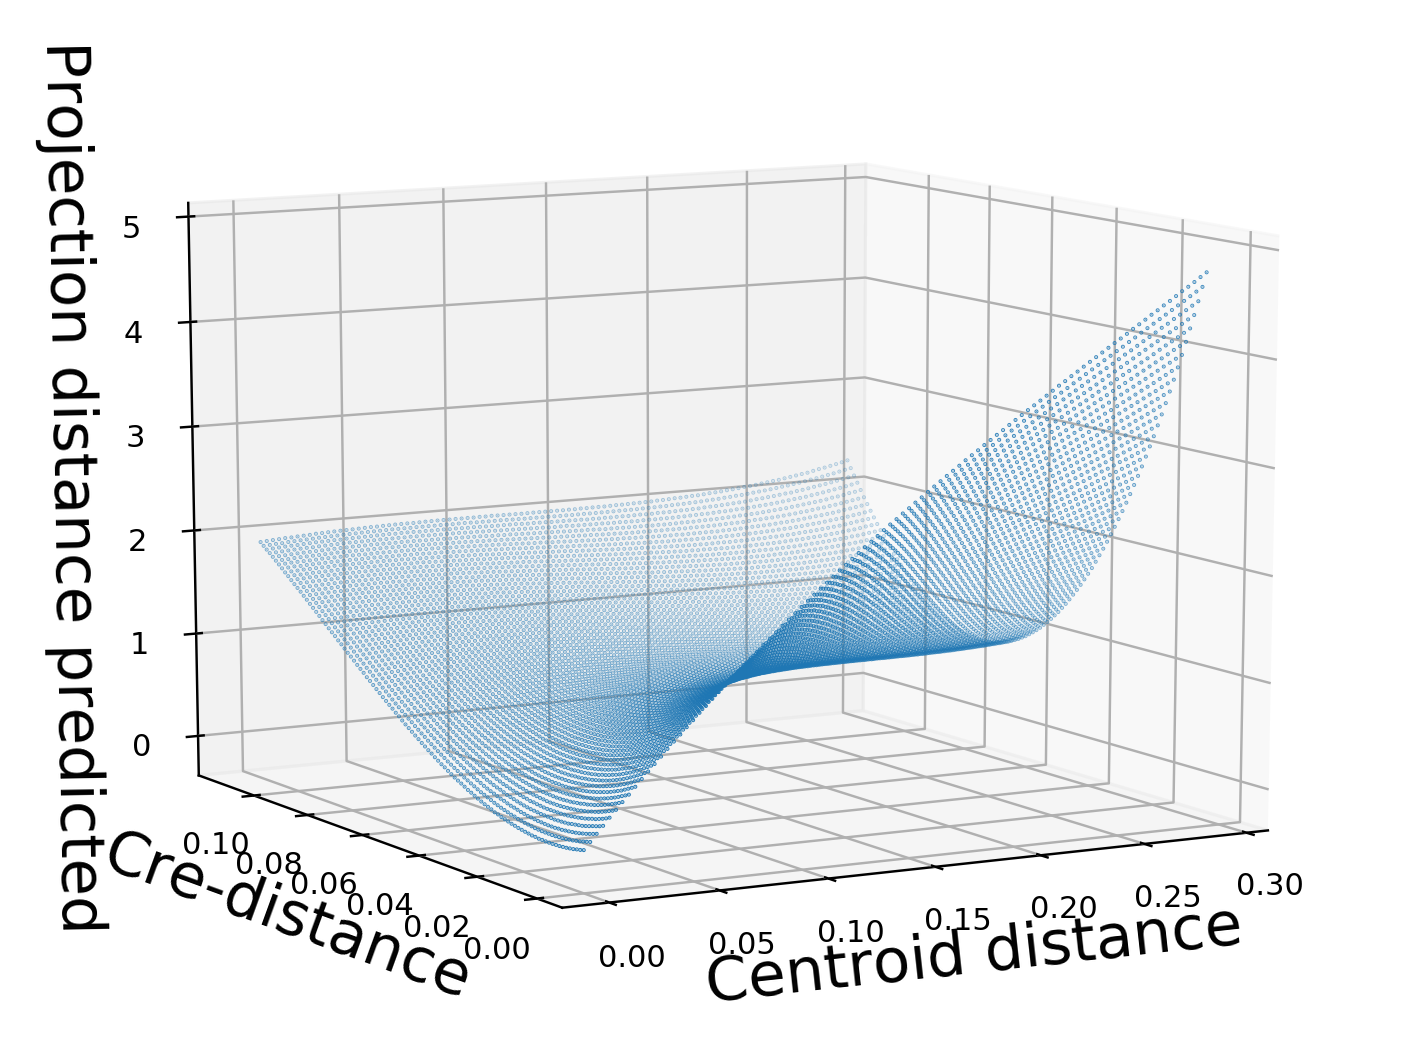

Text(0.5, 0, 'Projection distance predicted')

In [289]:

%matplotlib notebook
ds = pairwise_distances(msvds[sid].centroids)**2
cs = credist
ls = pairwise_distances(msvds[sid].reg_proj_vcount_norm_renorm)**2

#need source and target color
source = np.repeat(np.linspace(0,35, 36, dtype = int), 36)
target = np.tile(np.linspace(0,35, 36, dtype = int), 36)

ds2 = ds[np.where(~np.isnan(cs))]
cs2 = cs[np.where(~np.isnan(cs))]
source2 = source[np.where(~np.isnan(cs.flatten()))]
target2 = target[np.where(~np.isnan(cs.flatten()))]

dsnorm  = np.linalg.norm(ds2)
csnorm = np.linalg.norm(cs2)

ds2 = ds2/dsnorm
cs2 = cs2 / csnorm
ls2 = ls[np.where(~np.isnan(cs))]

dc = np.asarray([ds2,cs2,ls2]).transpose()

qqq = KernelRidge(kernel='rbf', alpha=0, gamma  = .05)
qqq.fit(dc[:,:2], dc[:,2:])
xs = np.linspace(0, dc[:,0].max(), 100)
ys = np.linspace(0, dc[:,1].max(), 100)
preds = np.empty((100,100))
for x in range(100):
    for y in range(100):
        preds[x,y] =qqq.predict(np.asarray([[xs[x], ys[y]]]))#asdf.predict(np.asarray([[xs[x], ys[y]]])) #qqq.predict(np.asarray([[xs[x], ys[y]]]))
        
        
        
mxy = np.asarray(np.meshgrid(xs,ys)).transpose()

#%matplotlib inline
fig = plt.figure()
ax = Axes3D(fig)

ax.scatter(mxy[:,:,0], 
           mxy[:,:,1], 
           preds, s= .1)

#ax.set_axis_off()
ax.set_xlabel('Centroid distance', fontsize=20, rotation=150)
ax.set_ylabel('Cre-distance', fontsize=20, rotation=150)
ax.set_zlabel('Projection distance predicted', fontsize=20, rotation=150)

In [66]:
# sid = 315
# msvd = msvds[sid]
# cres = creline[sid]
# eminors = experiments_minor_structures[sid]
# means_cast, cs = get_cre_similarity(msvd, cres,eminors)


In [282]:
#     nsamp = cres.shape[0]
#     credist = np.empty((nsamp,nsamp))
#     credist[:] = np.nan
#     for i in range(nsamp):
#         print(i)
#         rkeys = list(results[eminors[i]].keys())#np.asarray(list(results[experiments_minor_structures[sid][i]].keys()))
#         for j in range(nsamp):
#             t= tuple([cres[i], cres[j]])
#             if np.isin(t, rkeys).all():
#                 credist[i,j]  = results[eminors[i]][t]


In [ ]:
# def get_cre_dist(results, eminors,cres):
#     nsamp = cres.shape[0]
#     credist = np.empty((nsamp,nsamp))
#     credist[:] = np.nan
#     for i in range(nsamp):
#         rkeys = list(results[eminors[i]].keys())#np.asarray(list(results[experiments_minor_structures[sid][i]].keys()))
#         for j in range(nsamp):
#             t= tuple([cres[i], cres[j]])
#             if np.isin(t, rkeys).all():
#                 credist[i,j]  = results[eminors[i]][t]
#     return(credist)

In [94]:
gammas = np.asarray([0.1,.5,1,2,10])
for sid in major_structure_ids:
 
    
    msvds[sid].loocv_predictions_leaf_leaf2 = get_nwloocv_predictions_multimodel_merge_dists(msvds[sid].reg_proj_vcount_norm_renorm, 
                                                                                       sls[sid], 
                                                                                       gammas, 
                                                                                       indices_leaf2ormore[sid], 
                                                                                       indices_leaf2ormore[sid])

a= [list(range(5))]
keys = np.asarray(list(itertools.product(*a)))


reg_proj_vcount_norm_renorms= {}
nwloocv_leaf_leaf2 = {}
for sid in major_structure_ids:
    reg_proj_vcount_norm_renorms[sid ] = msvds[sid].reg_proj_vcount_norm_renorm
    nwloocv_leaf_leaf2[sid] = msvds[sid].loocv_predictions_leaf_leaf2

eval_indices_leaf2ormore = get_eval_indices(indices_leaf2ormore)

losses_leaf_leaf2 = get_loss(reg_proj_vcount_norm_renorms, nwloocv_leaf_leaf2,pred_ind = eval_indices_leaf2ormore, true_ind = eval_indices_leaf2ormore,keys = keys)
best_gamma_leaf_leaf2 = get_best_hyperparameters(losses_leaf_leaf2,keys)
meanloss_nw_leaf_leaf2 = get_loss_best_hyp(losses_leaf_leaf2, best_gamma_leaf_leaf2)

#meanloss_nw_leaf_leaf2wt
#meanloss_nw_wtleaf_leaf2wt

(13, 5, 36, 577)
(5, 5, 7, 577)
(18, 5, 122, 577)
(21, 5, 85, 577)
(119, 5, 1128, 577)
(23, 5, 68, 577)
(19, 5, 46, 577)
(9, 5, 35, 577)
(13, 5, 33, 577)
(7, 5, 30, 577)
(8, 5, 78, 577)
(29, 5, 83, 577)
0
1
2
3
4
5
6
7
8
9
10
11


In [96]:
best_gamma_leaf_leaf2

array([[0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [4],
       [0],
       [1]])

In [95]:
meanloss_nw_leaf_leaf2

array([0.65760652, 0.29068181, 0.28611965, 0.28694619, 0.27366809,
       0.45347513, 0.39194268, 0.35009547, 0.29830584, 0.52121181,
       0.36201588, 0.37376983])

In [97]:
output = pd.DataFrame(meanloss_nw_leaf_leaf2[[4,7,2,1,10,9,11,3,5,8,6,0]])

In [98]:
output.to_clipboard()

In [78]:
meanloss_nw_leaf_leaf2

array([0.66055727])

In [65]:
meanloss_nw_leaf_leaf2 #loss was lower with credist 0 for all structures and only nonzero within structure

array([0.56006544])

In [80]:
losses_leaf_leaf2[512][4]

array([0.33877918, 1.12506148, 0.65612922, 1.05800114, 0.71846603,
       0.37482175, 0.3034495 , 0.77660253, 1.65425879, 0.68369088,
       0.13559877, 0.67324777, 0.5819475 , 0.19371331, 0.24109897,
       0.97705736, 1.65425878, 1.64745881, 0.61091253, 1.22764314,
       0.6425    , 0.64250001, 0.70297127, 1.12506149, 0.37482176,
       0.85948511, 0.86742461, 0.48360763, 1.33074997, 0.80836303,
       0.94872796])

In [580]:
losses_leaf_leaf2[512][4]

array([0.33895654, 1.12506148, 0.65214848, 1.05743087, 0.71980092,
       0.37482175, 0.29558515, 0.76298279, 1.65425879, 0.70196086,
       0.13553246, 0.69194675, 0.59201107, 0.18915397, 0.24130291,
       0.98358534, 1.65425878, 1.65162293, 0.65711188, 1.23026055,
       0.6425    , 0.64250001, 0.74876376, 1.12506149, 0.37482176,
       0.85544192, 0.86784784, 0.47623823, 1.34965419, 0.82068764,
       1.02282031])

In [612]:
sls[sid]

array([[nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan]])

In [613]:
sid

512